# MSLS and ILS

## Imports

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import seaborn as sns
import random
random.seed(42)
import time
import heapq
from sortedcontainers import SortedList

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
TSPA_PATH = "../data/TSPA.csv"
TSPB_PATH = "../data/TSPB.csv"

In [3]:
df = pd.read_csv(TSPA_PATH, sep=";", header=None)
df.columns = ["x", "y", "val"]
df

x     y   val
0    1355  1796   496
1    2524   387   414
2    2769   430   500
3    3131  1199  1133
4     661    87   903
..    ...   ...   ...
195   189  1151  1145
196  3688   759   727
197   973   984  1637
198   910  1383  1255
199   262  1669  1307

[200 rows x 3 columns]

In [4]:
def math_round(n):
    '''
    Mathematically rounds up to the nearest integer, always rounds up for 0.5

    ParametersL
    n: floating point number to round
    '''
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [5]:
def plot_nodes_with_lines(df, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = 'Nodes with Color-Scaled Values' if connections is None else 'Nodes with Values and Connections'
    plt.title(title)
    plt.grid(False)
    plt.show()


def get_distance_matrix(df, distance_function):
    """
    Calculates the distance matrix for a set of nodes using the given distance function.

    Parameters:
    nodes: DataFrame of nodes, each with 'x', 'y', and 'val'.
    distance_function: function that takes two points (x1, y1) and (x2, y2) and returns the distance.

    Returns:
    A 2D numpy array representing the distance matrix.
    """
    positions = df[["x", "y"]]
    num_nodes = len(positions)
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.int64)

    for i in range(num_nodes):
        for j in range(i, num_nodes):
            dist = round(distance_function(positions.iloc[i], positions.iloc[j]))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    return distance_matrix


def calculate_score(solution, matrix, weights):
    '''
    Calculates solution score based on the matrix of distances and provided weights array.

    Parameters:
    solution: List or array of the solution
    matrix: Numpy array with node distances (2D)
    weights: Numpy array with node weights (1D - vector)
    '''
    score = 0
    for i in range(len(solution)-1):
        node_1 = solution[i]
        node_2 = solution[i+1]
        score += (matrix[node_1][node_2] + weights[node_1])
    node_1 = solution[-1]
    node_2 = solution[0]
    score += (matrix[node_1][node_2] + weights[node_1])
    return score

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [6]:
def random_solution(distance_matrix, weights, start_node):
    '''
    Returns a random solution to the TSP problem based on the provided distance matrix.

    Parameters:
    distance_matrix: numpy.array containing distances between the nodes.
    weights: numpy.array containing the weights associated with each node.
    start_node: int, the index of the node from which the cycle starts.
    '''

    remaining_nodes = list(range(len(distance_matrix)))
    remaining_nodes.remove(start_node)
    np.random.shuffle(remaining_nodes)
    solution = [start_node] + remaining_nodes[:len(distance_matrix)//2 - 1]
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

In [7]:
distance_matrix = get_distance_matrix(df, euclidean_distance)
pd.DataFrame(distance_matrix)

0     1     2     3     4     5     6     7     8     9    ...   190  \
0       0  1831  1966  1874  1845  1097  1658  2297  2193  1364  ...  1977   
1    1831     0   249  1014  1887  1985   802  1872  1270  1027  ...  2173   
2    1966   249     0   850  2136  2209  1050  1698  1066   981  ...  2421   
3    1874  1014   850     0  2709  2513  1715   858   344   512  ...  2976   
4    1845  1887  2136  2709     0   888  1091  3487  3036  2396  ...   288   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
195  1333  2457  2679  2942  1164   473  1834  3537  3286  2486  ...  1087   
196  2553  1222   976   710  3101  3068  2023  1124   517  1212  ...  3384   
197   897  1662  1880  2169   950   345  1113  2824  2513  1741  ...  1085   
198   607  1897  2089  2229  1320   497  1462  2785  2569  1752  ...  1409   
199  1100  2600  2796  2907  1632   785  2100  3395  3242  2414  ...  1593   

      191   192   193   194   195   196   197   198   199  
0     746  1414   993  1527  1333  2553   897   607  1100  
1    2104  2213  2215  1016  2457  1222  1662  1897  2600  
2    2301  2447  2426  1264  2679   976  1880  2089  2796  
3    2442  2809  2632  1861  2942   710  2169  2229  2907  
4    1352   780  1214   874  1164  3101   950  1320  1632  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
195   587   384   342  1587     0  3521   802   757   523  
196  3063  3338  3231  2227  3521     0  2724  2847  3545  
197   529   649   563   890   802  2724     0   404   987  
198   216   807   419  1260   757  2847   404     0   708  
199   496   871   448  1872   523  3545   987   708     0  

[200 rows x 200 columns]

In [8]:
weights = df.val.to_numpy()
weights[:2]

array([496, 414], dtype=int64)

## Random

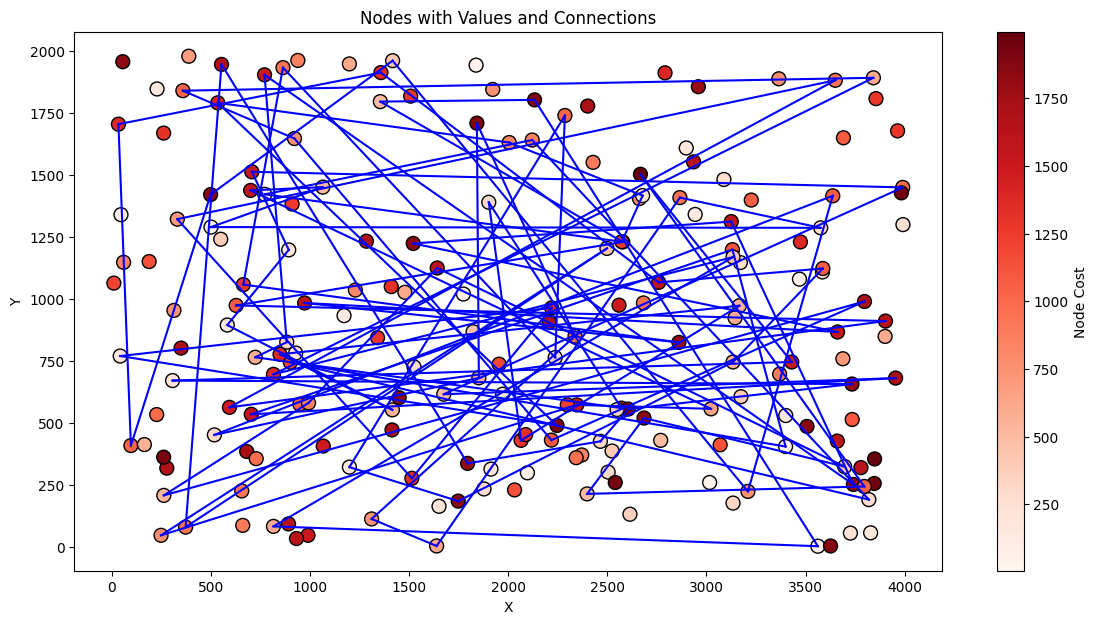

273509


In [9]:
start_solution, start_score = random_solution(distance_matrix, weights, start_node = 0)
plot_nodes_with_lines(df, start_solution)
print(start_score)

## Greedy Regret Weighted

In [10]:
def find_second_node_closest(start_node, matrix, weights):
    '''
    Finds the second node for the TSP cycle using a greedy approach, selecting the node closest
    to the start node based on the distance matrix and weights.

    Parameters:
    start_node: int, the index of the node from which the search for the second node starts.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    second_node: int, the index of the second node selected to form the initial cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    np.fill_diagonal(distance_matrix, np.inf)
    second_node = np.argmin(distance_matrix[:, start_node] + weights)
    return second_node

def find_second_node_regret(start_node, non_cycle_nodes, matrix, weights):
    '''
    Finds the second node using a regret-based heuristic. The regret is calculated as the difference 
    between the closest and second closest nodes, and the node with the highest regret is selected.

    Parameters:
    start_node: int, the index of the node from which the cycle starts.
    non_cycle_nodes: set of remaining nodes that are not yet in the cycle.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    best_node: int, the index of the selected second node based on the regret heuristic.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    best_node = None
    best_regret = -np.inf
    for node in non_cycle_nodes:
        start_node_cost = distance_matrix[start_node][node] + weights[node]
        distance_matrix[start_node][node] = np.inf
        smallest_cost = np.argmin(distance_matrix[node] + weights)
        regret = smallest_cost - start_node_cost
        if regret > best_regret:
            best_regret = regret
            best_node = node
    return best_node

def find_third_node(node_1, node_2, matrix, weights):
    '''
    Finds the third node for the TSP cycle by selecting the node that minimizes the total 
    distance from both the first and second nodes, considering node weights.

    Parameters:
    node_1: int, the index of the first node.
    node_2: int, the index of the second node.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    third_node: int, the index of the third node to complete the initial triangle of the cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    np.fill_diagonal(distance_matrix, np.inf)
    third_node = np.argmin(distance_matrix[:, node_1] + distance_matrix[:, node_2] + weights)
    return third_node


def calculate_score_three(solution, matrix, weights):
    '''
    Calculates the score (total distance) for a TSP cycle for the first three nodes. 

    Parameters:
    solution: list of three ints representing the node indices of the current cycle.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    score = 0
    node_1 = solution[0]
    node_2 = solution[1]
    node_3 = solution[2]
    score += matrix[node_1][node_2] + weights[node_1]
    score += matrix[node_2][node_3] + weights[node_2]
    score += matrix[node_3][node_1] + weights[node_3]
    return score

def update_score(solution, score, node, insert_location, matrix, weights):
    '''
    Updates the total score after inserting a node at a specified location in the solution. 

    Parameters:
    solution: List of nodes representing the current cycle.
    score: The current total score (cost) of the cycle before the node is inserted.
    node: int, the node to be inserted into the solution.
    insert_location: int, the index at which the node will be inserted.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    node_before = solution[insert_location - 1]
    node_after = solution[insert_location]
    score -= matrix[node_before][node_after]
    score += matrix[node_before][node] + matrix[node][node_after] + weights[node]
    return score

def find_second_node_closest_weighted(start_node, non_cycle_nodes, matrix, weights, regret_weight):
    '''
    Finds the second node for the TSP cycle using a mix of a weighted greedy and regret approaches
    to the start node based on the distance matrix and weights.

    Parameters:
    start_node: int, the index of the node from which the search for the second node starts.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    second_node: int, the index of the second node selected to form the initial cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)

    greedy_scores = []
    ordered_nodes = list(non_cycle_nodes)
    for node in non_cycle_nodes:
        greedy_score = distance_matrix[start_node][node] + weights[node]
        greedy_scores.append(greedy_score)

    regret_scores = []
    for node in non_cycle_nodes:
        start_node_cost = distance_matrix[start_node][node] + weights[node]
        distance_matrix[start_node][node] = np.inf
        smallest_cost = np.argmin(distance_matrix[node] + weights)
        regret = smallest_cost - start_node_cost
        regret_scores.append(regret)

    greedy_scores = np.array(greedy_scores)
    regret_scores = np.array(regret_scores)
    total_scores = ((1 + regret_weight) * greedy_score) + (regret_weight * regret_scores)
    total_scores, ordered_nodes = zip(*sorted(zip(total_scores, ordered_nodes)))
    return ordered_nodes[0]

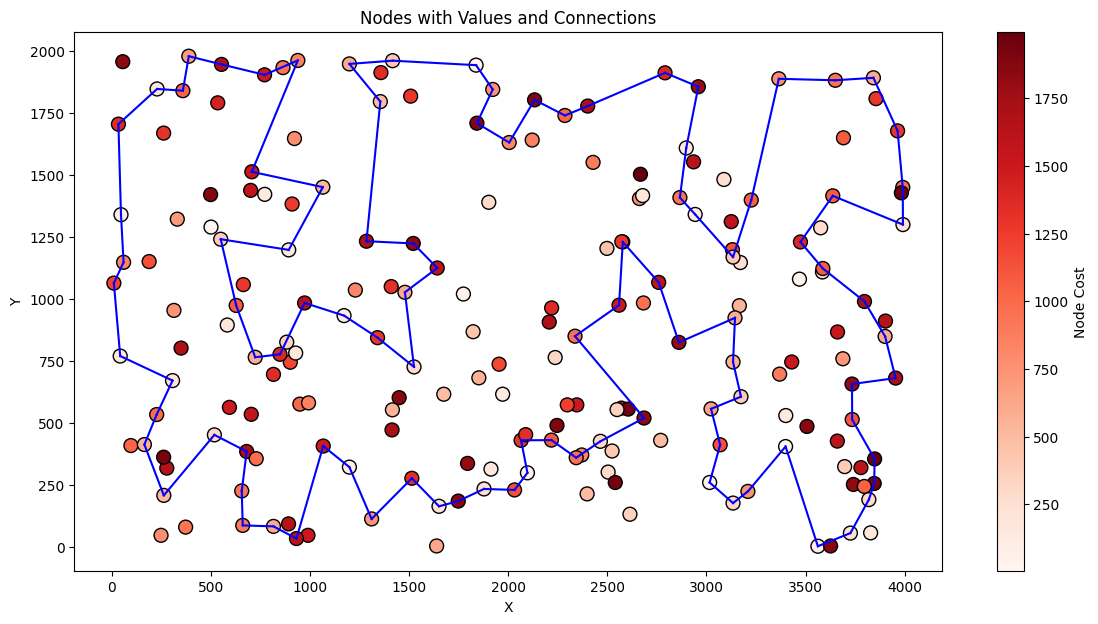

Acheived Total Score: 114964


In [11]:
def greedy_regret_cycle(matrix, weights, start_node):
    '''
    Implements a greedy regret cycle algorithm with regret to solve the Traveling Salesman Problem (TSP).

    Parameters:
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    starting_node: int, the index of the node from which the cycle starts.
    '''
    solution = [start_node]
    non_cycle_nodes = set([i for i in range(len(weights))])
    non_cycle_nodes.remove(start_node)
    num_iterations = int((len(weights) // 2) - 3)
    second_node = find_second_node_closest(start_node, matrix, weights)
    #second_node = find_second_node_regret(start_node, non_cycle_nodes, matrix, weights)
    solution.append(second_node)
    non_cycle_nodes.remove(second_node)
    third_node = find_third_node(start_node, second_node, matrix, weights)
    solution.append(third_node)
    non_cycle_nodes.remove(third_node)
    score = calculate_score_three(solution, matrix, weights)

    for i in range(num_iterations):
        best_regret = -np.inf
        best_node = None
        best_location = None
        best_score = None
        for node in non_cycle_nodes:
            scores = []
            score_locations = []
            for insert_location in range(len(solution)):
                #insert_location = (insert_location + 1) % len(solution) MIGHT NEED TO UNCOMMENT THIS
                temp_score = update_score(solution, score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
            scores = list(scores)
            score_locations = list(score_locations)
            regret = scores[1] - scores[0]
            regret_location = score_locations[0]
            if regret > best_regret:
                best_regret = regret
                best_node = node
                best_location = regret_location
                best_score = scores[0]
        solution.insert(best_location, best_node)
        score = best_score
        non_cycle_nodes.remove(best_node)
    return solution, score

start_node = 0
solution, score = greedy_regret_cycle(distance_matrix, weights, start_node)
plot_nodes_with_lines(df, solution)
print(f"Acheived Total Score: {score}")

## Delta Steepest Search and Steepest Search

Total time for 10 solutions: 4.731739044189453


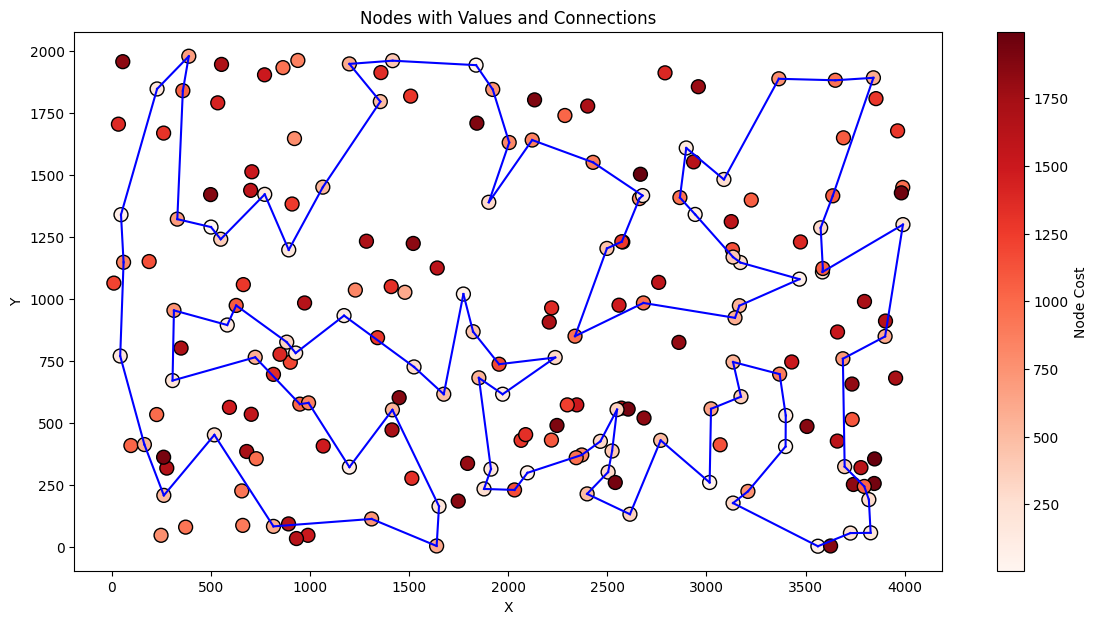

Achieved Total Score: 73982


In [12]:
def update_score(solution, score, node, insert_location, matrix, weights):
    '''
    Updates the total score after inserting a node at a specified location in the solution. 

    Parameters:
    solution: List of nodes representing the current cycle.
    score: The current total score (cost) of the cycle before the node is inserted.
    node: int, the node to be inserted into the solution.
    insert_location: int, the index at which the node will be inserted.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    node_before = solution[insert_location - 1]
    node_after = solution[insert_location]
    score -= matrix[node_before][node_after]
    score += matrix[node_before][node] + matrix[node][node_after] + weights[node]
    return score


def update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    '''
    Calculates the score after changing the node with an outside node in remaining_nodes. Only used when a new move appears.
    '''
    node_1 = solution[cycle_position]
    node_2 = remaining_nodes[relative_node_position]
    node_before = solution[cycle_position - 1]
    node_after = solution[(cycle_position + 1) % num_cycle_nodes]
    score -= distance_matrix[node_1][node_before]
    score -= distance_matrix[node_1][node_after]
    score -= weights[node_1]
    score += distance_matrix[node_2][node_before]
    score += distance_matrix[node_2][node_after]
    score += weights[node_2]
    return score

def update_score_inter_edge(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    '''
    Calculates the score after changing the solution by exchanging edges. Only used when a new move appears.
    '''
    temp_score -= distance_matrix[solution[cycle_position]][solution[cycle_position+1]]
    temp_score -= distance_matrix[solution[any_node_position]][solution[(any_node_position + 1) % num_cycle_nodes]]

    temp_score += distance_matrix[solution[cycle_position]][solution[any_node_position]]
    temp_score += distance_matrix[solution[cycle_position+1]][solution[(any_node_position + 1) % num_cycle_nodes]]
    return temp_score

def node_intra_change_steepest_fast(move_score, score, solution, cycle_position, relative_node_position, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index):
    '''
    Calculates the new solution and score after applying a move by exchanging node with a node from remaining_nodes. Also updates indexes and sets.
    '''
    solution_set.remove(solution[cycle_position])
    solution_set.add(remaining_nodes[relative_node_position])
    remaining_nodes_set.add(solution[cycle_position])
    remaining_nodes_set.remove(remaining_nodes[relative_node_position])
    solution_index[remaining_nodes[relative_node_position]] = cycle_position
    remaining_nodes_index[solution[cycle_position]] = relative_node_position
    solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
    return score + move_score, solution, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index

def edge_inter_change_steepest_fast(move_score, score, solution, cycle_position, any_node_position, solution_index):
    '''
    Calculates the new solution and score after applying a move by exchanging edges. Also updates indexes and sets.
    '''
    solution[cycle_position+1:any_node_position+1] = solution[cycle_position+1:any_node_position+1][::-1]
    for i in range(cycle_position + 1, any_node_position + 1):
        solution_index[solution[i]] = i
    return score + move_score, solution, solution_index

def get_initial_moves(solution, cycle_positions, remaining_positions, num_cycle_nodes, score, remaining_nodes, distance_matrix, weights):
    '''
    Produces the initial moves.
    '''
    moves = SortedList()
    already_added_inter = set()
    already_added_edges = set()

    for cycle_position in cycle_positions:
        for relative_node_position in range(len(remaining_positions)):
            temp_score = update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            move_score = temp_score - score
            node_before = solution[cycle_position - 1]
            node_after = solution[(cycle_position + 1) % num_cycle_nodes]
            already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], node_before, node_after))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], node_before, node_after), 0)) # 0 for intra

        for any_node_position in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
                continue
            temp_score = update_score_inter_edge(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            move_score = temp_score - score
            node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
            node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
            already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1)) # 1 for inter

    return moves, already_added_inter, already_added_edges

def update_moves_intra(score, solution, moves, already_added_inter, already_added_edges, cycle_position, remaining_positions, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    '''
    Updates moves after an echange of nodes.
    '''
    for relative_node_position in range(len(remaining_positions)):
        prev_node = solution[cycle_position - 1]
        next_node = solution[(cycle_position + 1) % num_cycle_nodes]
        if (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node) in already_added_inter:
            continue
        temp_score = update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
        move_score = temp_score - score
        already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node))
        if move_score >= 0:
            continue
        moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node), 0))

    for any_node_position in range(cycle_position + 2, num_cycle_nodes):
        if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
            continue
        node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
        node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
        if (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2) in already_added_edges:
            continue
        temp_score = update_score_inter_edge(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
        move_score = temp_score - score
        already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
        if move_score >= 0:
            continue
        moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1))
        
    return moves, already_added_inter, already_added_edges

def update_moves_inter_edge(score, cycle_positions, solution, moves, num_cycle_nodes, distance_matrix, remaining_nodes, already_added_inter, already_added_edges, remaining_positions, weights):
    '''
    Updates the moves after an exchange of edges.
    '''
    for cycle_position in cycle_positions:
        for any_node_position in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
                continue
            node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
            node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
            if (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2) in already_added_edges:
                continue
            temp_score = update_score_inter_edge(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            move_score = temp_score - score
            already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1))

    for cycle_position in cycle_positions:
        for relative_node_position in range(len(remaining_positions)):
            prev_node = solution[cycle_position - 1]
            next_node = solution[(cycle_position + 1) % num_cycle_nodes]
            if (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node) in already_added_inter:
                continue
            temp_score = update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            move_score = temp_score - score
            already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node), 0))

    return moves, already_added_inter, already_added_edges

def init_index_dict(values):
    '''
    Creates a dictionary of of indexes for each value.
    '''
    index_dict = {}
    for i in range(len(values)):
        index_dict[values[i]] = i
    return index_dict

def deltas_steepest_local_search_edges(solution, score, distance_matrix, weights):
    num_cycle_nodes = len(solution)
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(num_cycle_nodes)]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    remaining_positions = list(set(all_node_positions) - set(cycle_positions))
    solution_set = set(solution)
    remaining_nodes_set = set(remaining_nodes)
    solution_index = init_index_dict(solution)
    remaining_nodes_index = init_index_dict(remaining_nodes)

    moves, already_added_inter, already_added_edges = get_initial_moves(solution, cycle_positions, remaining_positions, num_cycle_nodes, score, remaining_nodes, distance_matrix, weights)
    while True:
        i = 0
        while i < len(moves):
            move_score, move, inter = moves[i]
            if not inter:
                cycle_node, any_node, node_before, node_after = move
                if cycle_node not in solution_set or any_node not in remaining_nodes_set:
                    moves.remove(moves[i])
                    already_added_inter.remove(move)
                    continue
                cycle_position = solution_index[cycle_node]
                if node_before != solution[cycle_position - 1] or node_after != solution[(cycle_position + 1) % num_cycle_nodes]:
                    moves.remove(moves[i])
                    already_added_inter.remove(move)
                    continue
                relative_node_position = remaining_nodes_index[any_node]
                score, solution, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index = node_intra_change_steepest_fast(move_score, score, solution, cycle_position, relative_node_position, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index)
                moves, already_added_inter, already_added_edges = update_moves_intra(score, solution, moves, already_added_inter, already_added_edges, cycle_position, remaining_positions, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
                i = 0
            else:
                if move[0] not in solution_set or move[1] not in solution_set:
                    moves.remove(moves[i])
                    already_added_edges.remove(move)
                    continue
                cycle_node, any_node, node_after_cycle, node_after_any = move
                cycle_position = solution_index[cycle_node]
                any_node_position = solution_index[any_node]
                if cycle_position > any_node_position:
                    i += 1
                    continue # We got turned around ;(
                if node_after_cycle != solution[(cycle_position + 1) % num_cycle_nodes] or node_after_any != solution[(any_node_position + 1) % num_cycle_nodes]:
                    moves.remove(moves[i])
                    already_added_edges.remove(move)
                    continue
                score, solution, solution_index = edge_inter_change_steepest_fast(move_score, score, solution, cycle_position, any_node_position, solution_index)
                moves, already_added_inter, already_added_edges = update_moves_inter_edge(score, cycle_positions, solution, moves, num_cycle_nodes, distance_matrix, remaining_nodes, already_added_inter, already_added_edges, remaining_positions, weights)
                i = 0

        return solution, score

start_time = time.time()
for i in range(10):
    random_solution_result, random_solutionscore = random_solution(distance_matrix, weights, start_node = i)
    random_solution_result, random_solutionscore = deltas_steepest_local_search_edges(random_solution_result, random_solutionscore, distance_matrix, weights)
end_time = time.time()


print(f"Total time for 10 solutions: {end_time - start_time}")
start_solution, start_score = random_solution(distance_matrix, weights, start_node = 0)
solution, score = deltas_steepest_local_search_edges(start_solution, start_score, distance_matrix, weights)
plot_nodes_with_lines(df, solution)
print(f"Achieved Total Score: {score}")

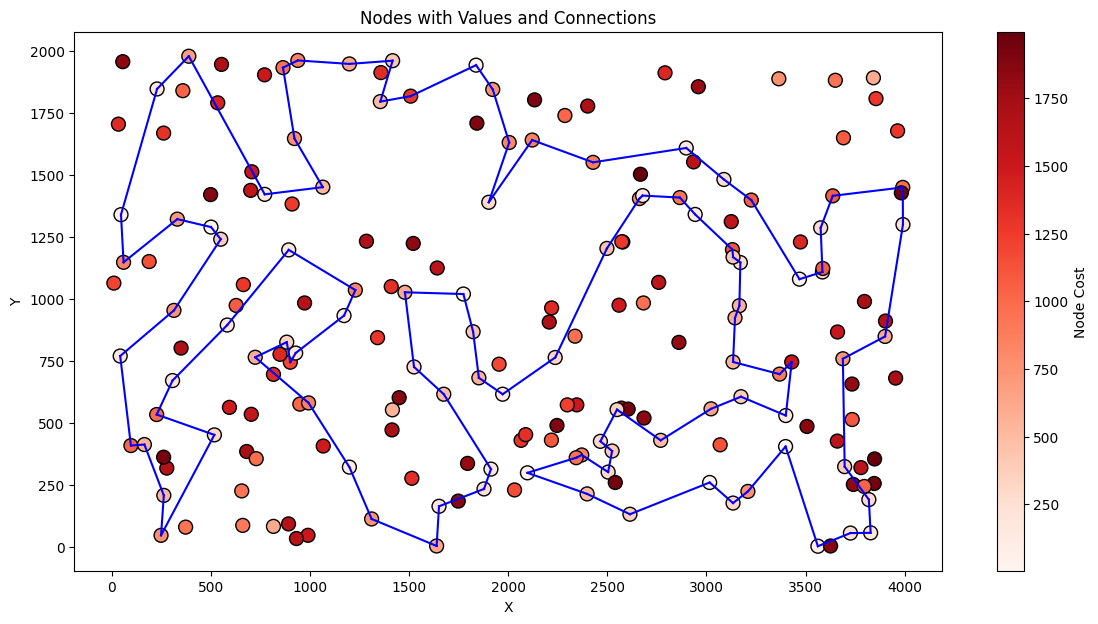

Achieved Total Score: 72951


In [13]:
def update_score_intra_edge(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    # cycle position, any node position - positions of nodes in the solution that mark the beginning of selected edge
    temp_score -= distance_matrix[solution[cycle_position]][solution[cycle_position+1]]
    temp_score -= distance_matrix[solution[any_node_position]][solution[(any_node_position + 1) % num_cycle_nodes]]

    temp_score += distance_matrix[solution[cycle_position]][solution[any_node_position]]
    temp_score += distance_matrix[solution[cycle_position+1]][solution[(any_node_position + 1) % num_cycle_nodes]]
    return temp_score


def node_inter_change_steepest(score, solution, cycle_position, any_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    temp_score = score
    relative_node_position = any_node_position - num_cycle_nodes
    temp_score = update_score_inter(temp_score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
    solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
    return temp_score, solution, remaining_nodes

def edge_intra_change_steepest(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    temp_score = score
    temp_score = update_score_intra_edge(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
    solution[cycle_position+1:any_node_position+1] = solution[cycle_position+1:any_node_position+1][::-1]

    return temp_score, solution

def steepest_local_search_edges(solution, score, distance_matrix, weights):
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(len(solution))]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    remaining_positions = list(set(all_node_positions) - set(cycle_positions))
    num_cycle_nodes = len(solution)

    moves = []
    for cycle_position in cycle_positions:
        # Consider only inter moves for two-nodes exchange
        for any_node in remaining_positions:
            moves.append((cycle_position, any_node))

        # Consider intra edges for edge exchange (edge starting nodes added to moves)
        for any_node in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node == num_cycle_nodes - 1):
                continue
            moves.append((cycle_position, any_node))

    improvement = True
    while improvement:
        improvement = False
        random.shuffle(moves)
        best_score = np.inf
        best_solution = None
        best_remaining_nodes = remaining_nodes.copy()
        for cycle_position, any_node_position in moves:
            if any_node_position >= num_cycle_nodes:
                temp_score, temp_solution, temp_remaining_nodes = node_inter_change_steepest(score, solution.copy(), cycle_position, any_node_position, remaining_nodes.copy(), num_cycle_nodes, distance_matrix, weights)
            else:
                temp_score = score
                temp_solution = solution.copy()
                temp_score, temp_solution = edge_intra_change_steepest(score, solution.copy(), cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
                temp_remaining_nodes = remaining_nodes.copy()

            if temp_score < best_score:
                best_score = temp_score
                best_solution = temp_solution.copy()
                best_remaining_nodes = temp_remaining_nodes.copy()

        if best_score < score:
            score = best_score
            improvement = True
            solution = best_solution.copy()
            remaining_nodes = best_remaining_nodes.copy()

    return solution, score

start_solution, start_score = random_solution(distance_matrix, weights, start_node = 0)
solution, score = steepest_local_search_edges(start_solution.copy(), start_score, distance_matrix, weights)
plot_nodes_with_lines(df, solution)
print(f"Achieved Total Score: {score}")

## Evolutionary

In [14]:
import heapq

class PopulationContainer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.heap = []

    def add_solution(self, value, solution):
        rejected = None
        if len(self.heap) < self.max_size:
            heapq.heappush(self.heap, (-1*value, solution))
        else:
            rejected = heapq.heappushpop(self.heap, (-1*value, solution))
            return rejected[0]

    def get_solutions(self):
        return sorted(self.heap, key= lambda x: x[0], reverse=True)
    
    def choose_parents(self):
        return random.sample(self.heap, 2)

In [15]:
def create_initial_population_local_search(pop_size, distance_matrix, weights):
    population = []
    for i in range(pop_size):
        new_solution, new_score = random_solution(distance_matrix, weights, start_node = random.randint(0, len(weights)-1))
        new_solution, new_score = deltas_steepest_local_search_edges(new_solution, new_score, distance_matrix, weights)
        population.append((new_score, new_solution))
    return population

def fill_Nones_with_random(child, remaining_nodes):
    for i in range(len(child)):
        if child[i] == None:
            # new_node = random.sample(remaining_nodes, 1)[0]
            new_node = random.choice(tuple(remaining_nodes))

            child[i] = new_node
            remaining_nodes.remove(new_node)
    return child

def common_and_random_recombination(solution_1, solution_2, all_nodes, distance_matrix, weights):
    parent_1_dict = {node: idx for idx, node in enumerate(solution_1)}
    parent_2_dict = {node: idx for idx, node in enumerate(solution_2)}
    child_1 = [None for i in range(len(solution_1))]
    child_2 = [None for i in range(len(solution_2))]
    common_nodes = set(solution_1).intersection(set(solution_2))
    remaining_nodes = all_nodes - common_nodes
    for node in common_nodes:
        child_1[parent_1_dict[node]] = node
        child_2[parent_2_dict[node]] = node
    child_1 = fill_Nones_with_random(child_1, remaining_nodes.copy())
    child_2 = fill_Nones_with_random(child_2, remaining_nodes.copy())
    return child_1, child_2

def greedy_regret_cycle_genetic(solution, score, non_cycle_nodes, matrix, weights):
    num_iterations = (len(weights)//2 - len(solution))
    for i in range(num_iterations):
        best_regret = -np.inf
        best_node = None
        best_location = None
        best_score = None
        for node in non_cycle_nodes:
            scores = []
            score_locations = []
            for insert_location in range(len(solution)):
                temp_score = update_score(solution, score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
            scores = list(scores)
            score_locations = list(score_locations)
            regret = scores[1] - scores[0]
            regret_location = score_locations[0]
            if regret > best_regret:
                best_regret = regret
                best_node = node
                best_location = regret_location
                best_score = scores[0]
        solution.insert(best_location, best_node)
        score = best_score
        non_cycle_nodes.remove(best_node)
    return solution

def common_and_heuristic_recombination(solution_1, solution_2, all_nodes, distance_matrix, weights):
    sol1_set = set(solution_1)
    sol2_set = set(solution_2)
    child_1 = list(sol1_set.intersection(sol2_set))
    child_2 = list(sol2_set.intersection(sol1_set))
    remaining_nodes_1 = all_nodes - set(child_1)
    remaining_nodes_2 = all_nodes - set(child_2)

    child_1_score = calculate_score(child_1, distance_matrix, weights)
    child_2_score = calculate_score(child_2, distance_matrix, weights)
    child_1 = greedy_regret_cycle_genetic(child_1, child_1_score, remaining_nodes_1, distance_matrix, weights)
    child_2 = greedy_regret_cycle_genetic(child_2, child_2_score, remaining_nodes_2, distance_matrix, weights)
    return child_1, child_2

def add_edges_from_solution(solution, edge_list):
    n = len(solution)
    for i in range(n):
        left = solution[i - 1]  # Left neighbor
        right = solution[(i + 1) % n]  # Right neighbor
        edge_list[solution[i]].update([left, right])
    return edge_list

def add_nodes_from_edge_list(edge_list, current_node, solution_1, solution_2):
    child = []
    unvisited_nodes = set(solution_1 + solution_2)
    while len(child) < len(solution):
        child.append(current_node)

        for edges in edge_list.values():
            edges.discard(current_node)

        if edge_list[current_node]:
            next_node = min(edge_list[current_node], key=lambda x: len(edge_list[x]))
        else:
            unvisited_nodes = unvisited_nodes - set(child)
            next_node = random.choice(list(unvisited_nodes))
        
        current_node = next_node
    return child

def ERX_recombination(solution_1, solution_2, all_nodes, distance_matrix, weights):
    edge_list = {node: set() for node in all_nodes}
    edge_list = add_edges_from_solution(solution_1.copy(), edge_list)
    edge_list = add_edges_from_solution(solution_2.copy(), edge_list)
    current_node_1 = random.choice(solution_1)
    current_node_2 = random.choice(solution_2)
    child_1 = add_nodes_from_edge_list(edge_list, current_node_1, solution_1, solution_2)
    child_2 = add_nodes_from_edge_list(edge_list, current_node_2, solution_1, solution_2)

    remaining_nodes_1 = all_nodes - set(child_1)
    remaining_nodes_2 = all_nodes - set(child_2)
    # child_1[random.randint(0, len(child_1)-1)] = random.sample(remaining_nodes_1, 1)[0]
    # child_2[random.randint(0, len(child_2)-1)] = random.sample(remaining_nodes_2, 1)[0]
    child_1[random.randint(0, len(child_1)-1)] = random.choice(tuple(remaining_nodes_1))
    child_2[random.randint(0, len(child_2)-1)] = random.choice(tuple(remaining_nodes_2))
    return child_1, child_2


def evolutionary_solution(distance_matrix, weights, allowed_time, create_initial_population, pop_size, recombination, local_search=True):
    #start_time = time.time() maybe here, maybe later, idk
    initial_population = create_initial_population(pop_size, distance_matrix, weights)
    population = PopulationContainer(pop_size)
    population_scores = []
    all_nodes = set([i for i in range(len(weights))])

    for individual in initial_population:
        score, solution = individual
        population_scores.append(-1*score)
        population.add_solution(score, solution.copy())
        
    population_scores = set(population_scores)
    start_time = time.time()
    end_time = start_time
    num_iterations = 0
    while (end_time - start_time) < allowed_time:
        num_iterations += 1

        parent_1, parent_2 = population.choose_parents()
        parent_1 = parent_1[-1]
        parent_2 = parent_2[-1]
        # print(num_iterations, "Pre rec")
        child_1, child_2 = recombination(parent_1, parent_2, all_nodes, distance_matrix, weights)
        child_score_1 = calculate_score(child_1, distance_matrix, weights)
        child_score_2 = calculate_score(child_2, distance_matrix, weights)
        # print(num_iterations, "Post rec")

        if local_search:
            child_1, child_score_1 = deltas_steepest_local_search_edges(child_1.copy(), child_score_1, distance_matrix, weights)
            child_2, child_score_2 = deltas_steepest_local_search_edges(child_2.copy(), child_score_2, distance_matrix, weights)

        if -1*child_score_1 in population_scores:
            end_time = time.time()
        else:
            population_scores.add(-1*child_score_1)
            rejected_score = population.add_solution(child_score_1, child_1)
            population_scores.remove(rejected_score)

        if -1*child_score_2 in population_scores:
            end_time = time.time()
        else:
            population_scores.add(-1*child_score_2)
            rejected_score = population.add_solution(child_score_2, child_2)
            population_scores.remove(rejected_score)

        end_time = time.time()

    return population.get_solutions(), num_iterations

## ------------------------------------------------------------------------------------ Version with whole history ------------------------------------------------------------------------------------ 

def evolutionary_solution_entire_history(distance_matrix, weights, allowed_time, create_initial_population, pop_size, recombination, local_search=True):
    entire_history = []
    #start_time = time.time() maybe here, maybe later, idk
    initial_population = create_initial_population(pop_size, distance_matrix, weights)
    population = PopulationContainer(pop_size)
    population_scores = []
    all_nodes = set([i for i in range(len(weights))])

    for individual in initial_population:
        score, solution = individual
        population_scores.append(-1*score)
        population.add_solution(score, solution.copy())

    entire_history.append(population.get_solutions().copy())
    population_scores = set(population_scores)
    start_time = time.time()
    end_time = start_time
    num_iterations = 0
    while (end_time - start_time) < allowed_time:
        num_iterations += 1

        children = []
        parent_1, parent_2 = population.choose_parents()
        parent_1 = parent_1[-1]
        parent_2 = parent_2[-1]
        child_1, child_2 = recombination(parent_1, parent_2, all_nodes, distance_matrix, weights)
        child_score_1 = calculate_score(child_1, distance_matrix, weights)
        child_score_2 = calculate_score(child_2, distance_matrix, weights)

        if local_search:
            child_1, child_score_1 = deltas_steepest_local_search_edges(child_1.copy(), child_score_1, distance_matrix, weights)
            child_2, child_score_2 = deltas_steepest_local_search_edges(child_2.copy(), child_score_2, distance_matrix, weights)
        
        if -1*child_score_1 in population_scores:
            end_time = time.time()
        else:
            population_scores.add(-1*child_score_1)
            rejected_score = population.add_solution(child_score_1, child_1.copy())
            population_scores.remove(rejected_score)

        if -1*child_score_2 in population_scores:
            end_time = time.time()
        else:
            population_scores.add(-1*child_score_2)
            rejected_score = population.add_solution(child_score_2, child_2.copy())
            population_scores.remove(rejected_score)
        
        entire_history.append(population.get_solutions().copy())
        end_time = time.time()

    return entire_history, num_iterations

## Experiments

In [16]:
def copy_scores(solutions):
    temp = []
    for score, solution in solutions:
        temp.append(-1*score)
    return temp

import matplotlib.pyplot as plt

def plot_boxes_evolutionary(results, labels):
    if len(results) != len(labels):
        raise ValueError("The length of results and labels must be the same.")
    
    plt.figure(figsize=(10, 10))
    plt.boxplot(results, patch_artist=True)
    plt.xticks(ticks=range(1, len(labels) + 1), labels=labels, fontsize=12, rotation=45)
    plt.title("Box Plot of the Evolutionary Method", fontsize=14)
    plt.xlabel("Algorithm", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def get_scores_history(pop_history):
    scores = []
    for pop in pop_history:
        temp = []
        for indiv in pop:
            temp.append(-1*indiv[0])
        scores.append(temp.copy())
    return scores

def plot_learning_curve(scores_hist):
    if not scores_hist:
        raise ValueError("scores_hist cannot be empty.")
    
    min_scores = []
    mean_scores = []
    max_scores = []

    for iteration_scores in scores_hist:
        min_scores.append(np.min(iteration_scores))
        mean_scores.append(np.mean(iteration_scores))
        max_scores.append(np.max(iteration_scores))
    
    iterations = range(1, len(scores_hist) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, min_scores, label='Minimum Score', color='red', linestyle='--')
    plt.plot(iterations, mean_scores, label='Mean Score', color='blue', linestyle='-')
    plt.plot(iterations, max_scores, label='Maximum Score', color='green', linestyle='-.')
    plt.title("Learning Curve", fontsize=14)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

### TSPA

In [17]:
del df
del weights
del distance_matrix

In [18]:
allowed_time = 97.98816983699798

In [19]:
df_A = pd.read_csv(TSPA_PATH, sep=";", header=None)
df_A.columns = ["x", "y", "val"]
distance_matrix_A = get_distance_matrix(df_A, euclidean_distance)
weights_A = df_A.val.to_numpy()
weights_A[:2]

array([496, 414], dtype=int64)

In [20]:
TSPA_cumulative_results = []

#### Performance Experiments

Evolutionary Solution with Common + Random recombination, Local Search Used on TSPA
Achieved Best Score: 69836
Achieved Mean Score: 70002
Achieved Worst Score: 70126
70002 (69836 - 70126))
Solution: [131, 149, 123, 127, 70, 135, 154, 180, 53, 100, 26, 97, 152, 1, 101, 86, 75, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 92, 129, 57, 179, 196, 81, 90, 165, 119, 40, 185, 55, 52, 106, 178, 3, 14, 144, 49, 102, 62, 9, 148, 124, 94, 63, 79, 80, 133, 151, 162, 59, 118, 51, 176, 137, 23, 89, 183, 143, 0, 117, 93, 140, 108, 69, 18, 22, 146, 159, 193, 41, 139, 68, 46, 115, 5, 42, 181, 34, 160, 48, 54, 177, 10, 4, 112, 184, 43, 116, 65]
Number of iterations: 2801


C:\Users\barte\AppData\Local\Temp\ipykernel_820\3344569213.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


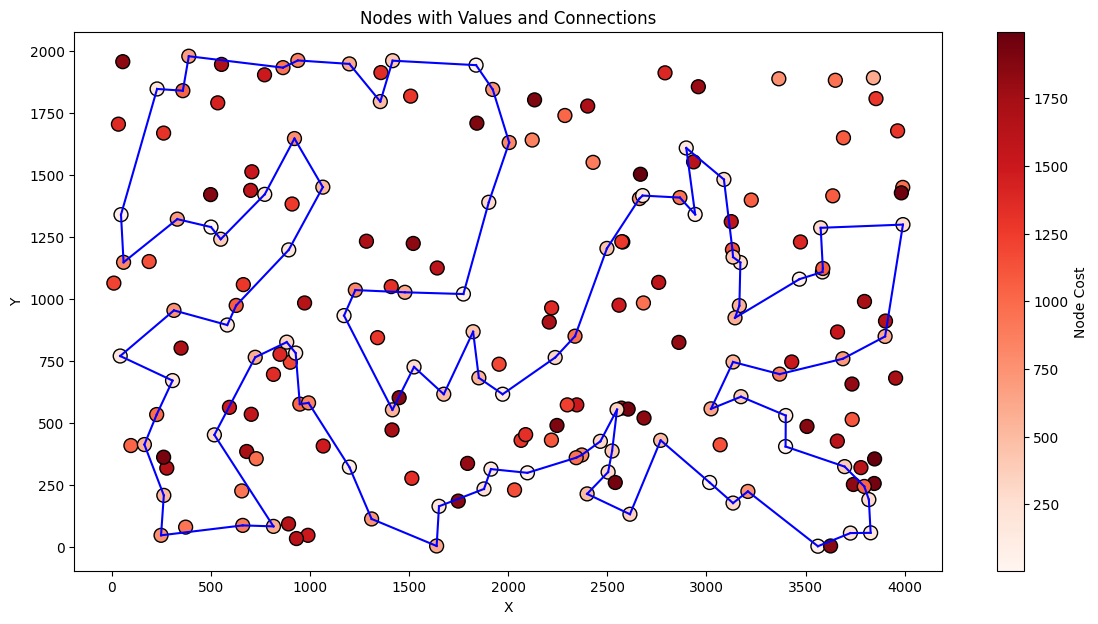

In [21]:
print("Evolutionary Solution with Common + Random recombination, Local Search Used on TSPA")
solutions, iterations = evolutionary_solution(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_random_recombination, local_search=True)

temp = copy_scores(solutions)
TSPA_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_A, solution)

Evolutionary Solution with Common + Random recombination, No Local Search on TSPA
Achieved Best Score: 72242
Achieved Mean Score: 74060
Achieved Worst Score: 76036
74060 (72242 - 76036))
Solution: [159, 193, 41, 139, 115, 59, 149, 131, 65, 116, 43, 42, 181, 34, 30, 54, 48, 160, 184, 177, 10, 190, 84, 4, 112, 127, 123, 162, 151, 51, 176, 80, 133, 79, 63, 136, 180, 135, 70, 154, 158, 53, 121, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 16, 171, 175, 113, 31, 78, 145, 92, 129, 57, 196, 81, 90, 27, 165, 40, 185, 55, 52, 106, 178, 3, 14, 144, 49, 102, 62, 9, 148, 167, 124, 94, 137, 89, 183, 143, 117, 0, 46, 68, 140, 108, 18, 22, 146, 195]
Number of iterations: 892080


C:\Users\barte\AppData\Local\Temp\ipykernel_820\586885759.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


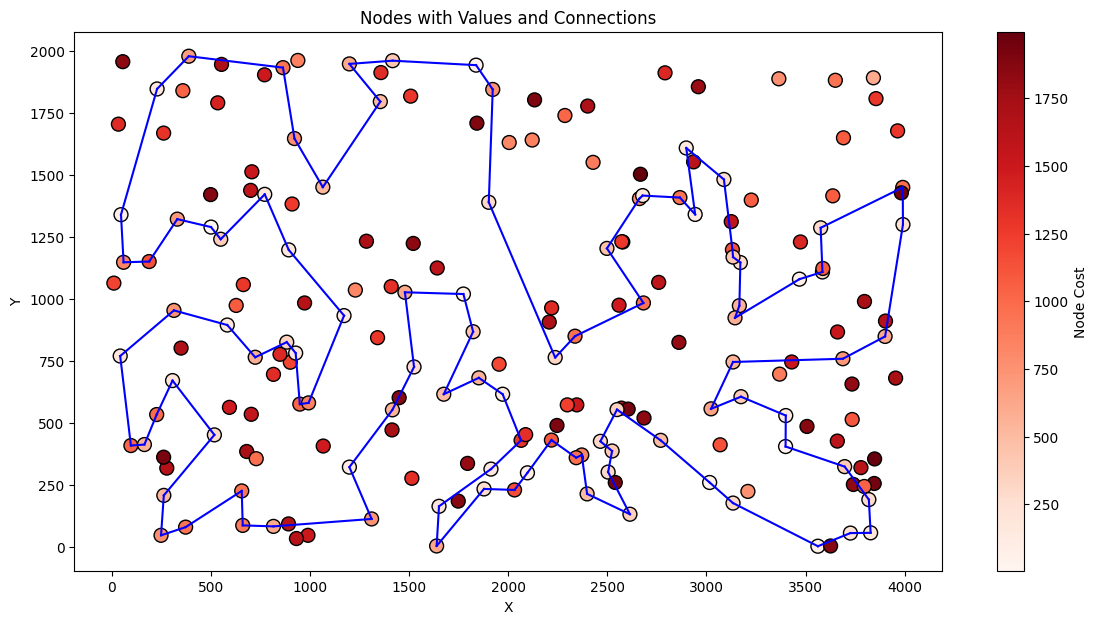

In [22]:
print("Evolutionary Solution with Common + Random recombination, No Local Search on TSPA")
solutions, iterations = evolutionary_solution(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_random_recombination, local_search=False)

temp = copy_scores(solutions)
TSPA_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_A, solution)

Evolutionary Solution with Common + Heuristic recombination, Local Search Used on TSPA
Achieved Best Score: 71881
Achieved Mean Score: 72396
Achieved Worst Score: 72708
72396 (71881 - 72708))
Solution: [1, 152, 94, 121, 53, 158, 180, 154, 135, 70, 127, 123, 162, 151, 133, 79, 63, 80, 176, 51, 59, 65, 149, 131, 184, 177, 54, 160, 42, 43, 116, 115, 41, 193, 159, 181, 34, 146, 22, 18, 69, 108, 140, 68, 139, 46, 0, 117, 143, 183, 89, 23, 137, 148, 9, 62, 102, 144, 14, 49, 3, 178, 106, 52, 55, 57, 129, 92, 145, 179, 185, 40, 119, 165, 39, 95, 7, 164, 27, 90, 81, 196, 157, 56, 113, 175, 171, 16, 31, 78, 25, 44, 120, 2, 75, 101, 86, 100, 26, 97]
Number of iterations: 101


C:\Users\barte\AppData\Local\Temp\ipykernel_820\2685977543.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


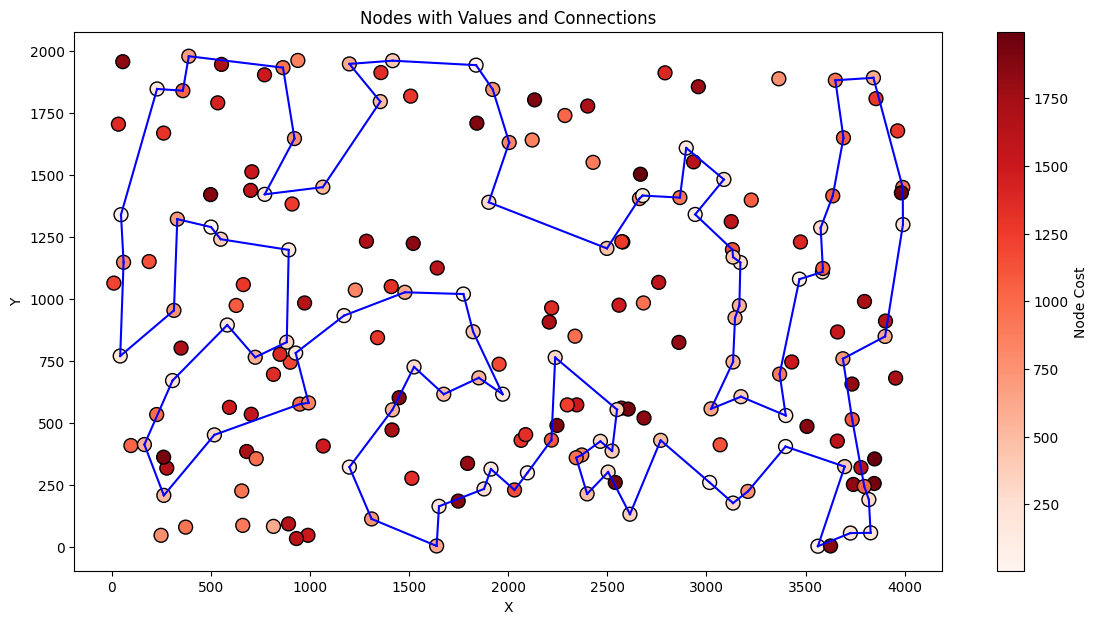

In [23]:
print("Evolutionary Solution with Common + Heuristic recombination, Local Search Used on TSPA")
solutions, iterations = evolutionary_solution(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_heuristic_recombination, local_search=True)

temp = copy_scores(solutions)
TSPA_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_A, solution)

Evolutionary Solution with Common + Heuristic recombination, No Local Search on TSPA
Achieved Best Score: 72050
Achieved Mean Score: 73600
Achieved Worst Score: 75872
73600 (72050 - 75872))
Solution: [31, 113, 175, 171, 16, 25, 44, 120, 82, 92, 57, 129, 2, 152, 97, 1, 101, 75, 86, 100, 26, 124, 94, 80, 176, 51, 151, 133, 79, 63, 121, 53, 158, 180, 154, 135, 70, 127, 123, 112, 4, 190, 10, 177, 54, 160, 184, 131, 149, 162, 118, 59, 65, 47, 116, 43, 42, 181, 34, 146, 22, 193, 41, 139, 115, 46, 68, 69, 18, 108, 140, 93, 117, 143, 183, 89, 23, 137, 148, 9, 62, 144, 14, 49, 3, 178, 106, 52, 55, 185, 40, 119, 165, 39, 27, 90, 81, 196, 145, 78]
Number of iterations: 445


C:\Users\barte\AppData\Local\Temp\ipykernel_820\2327330682.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


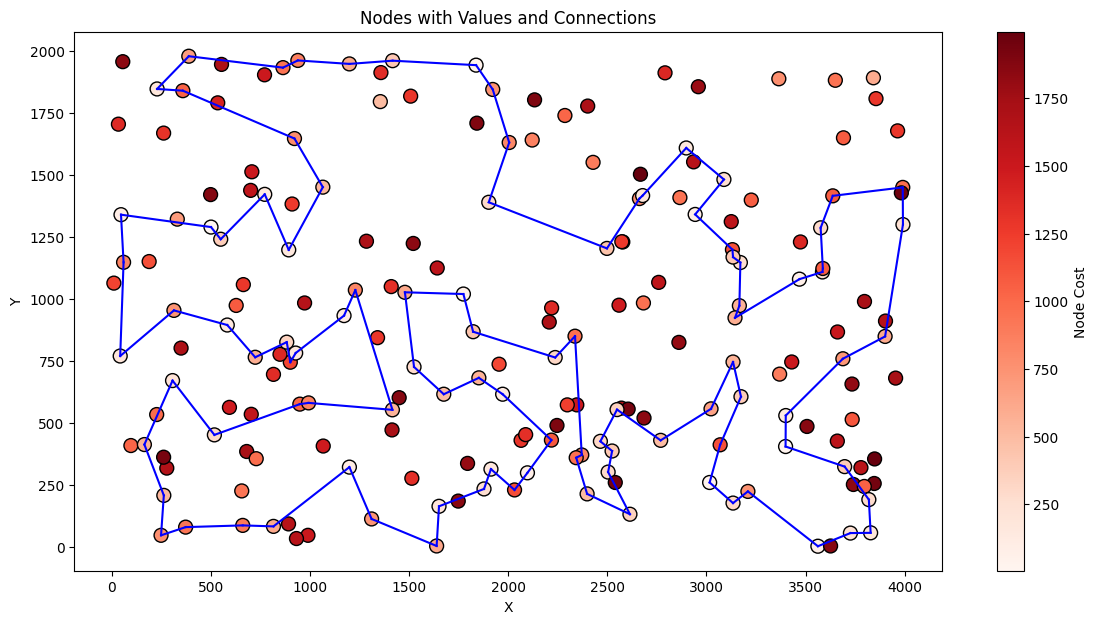

In [24]:
print("Evolutionary Solution with Common + Heuristic recombination, No Local Search on TSPA")
solutions, iterations = evolutionary_solution(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_heuristic_recombination, local_search=False)

temp = copy_scores(solutions)
TSPA_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_A, solution)

Evolutionary Solution with ERX recombination, Local Search Used on TSPA
Achieved Best Score: 70020
Achieved Mean Score: 70636
Achieved Worst Score: 70945
70636 (70020 - 70945))
Solution: [89, 186, 23, 137, 176, 51, 118, 59, 65, 116, 43, 131, 149, 162, 151, 133, 80, 79, 63, 94, 124, 148, 9, 62, 102, 144, 14, 49, 3, 178, 106, 52, 55, 57, 129, 92, 78, 145, 179, 185, 40, 165, 90, 81, 31, 113, 175, 171, 16, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100, 121, 53, 180, 154, 135, 70, 127, 123, 112, 84, 184, 190, 10, 177, 54, 48, 160, 34, 181, 42, 5, 115, 46, 68, 139, 41, 193, 159, 146, 22, 18, 69, 108, 140, 93, 117, 0, 143, 183]
Number of iterations: 178


C:\Users\barte\AppData\Local\Temp\ipykernel_820\3602223837.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


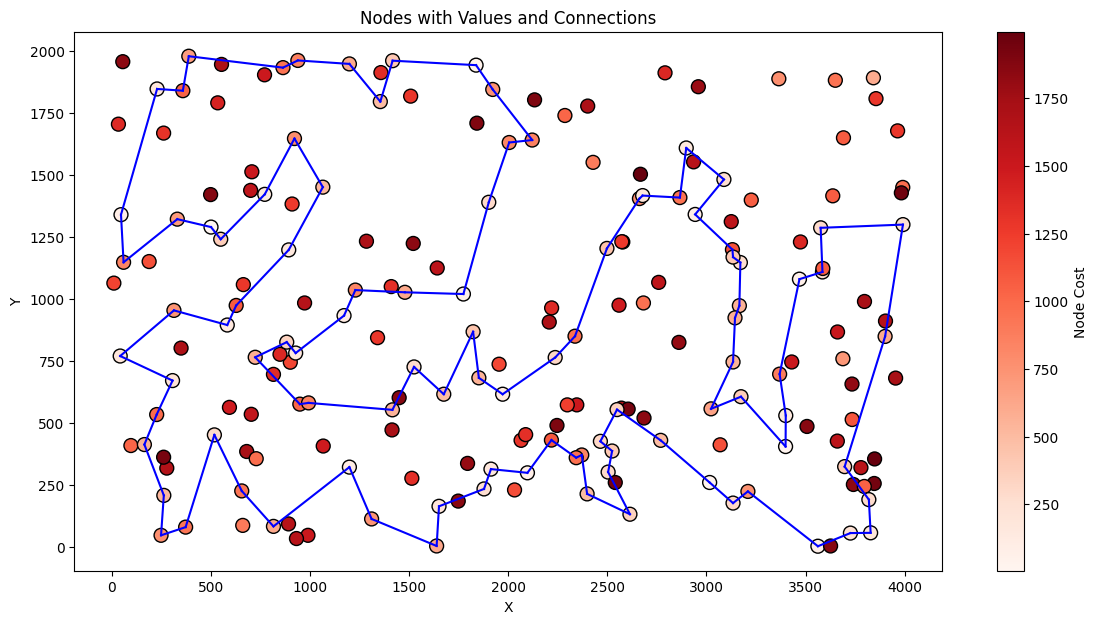

In [25]:
print("Evolutionary Solution with ERX recombination, Local Search Used on TSPA")
solutions, iterations = evolutionary_solution(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=ERX_recombination, local_search=True)

temp = copy_scores(solutions)
TSPA_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_A, solution)

Evolutionary Solution with ERX recombination, No Local Search on TSPA
Achieved Best Score: 73113
Achieved Mean Score: 74196
Achieved Worst Score: 76574
74196 (73113 - 76574))
Solution: [34, 103, 146, 22, 159, 193, 41, 5, 115, 139, 69, 18, 108, 68, 46, 0, 143, 183, 89, 186, 23, 137, 148, 9, 62, 144, 14, 102, 49, 3, 178, 106, 52, 185, 40, 119, 165, 39, 95, 7, 164, 58, 27, 90, 81, 196, 31, 56, 113, 175, 171, 16, 78, 145, 179, 55, 57, 92, 129, 25, 44, 120, 2, 152, 124, 94, 97, 1, 101, 75, 86, 53, 180, 154, 135, 151, 133, 79, 63, 80, 176, 51, 118, 59, 116, 65, 131, 149, 123, 112, 4, 84, 190, 10, 177, 184, 43, 42, 181, 160]
Number of iterations: 59939


C:\Users\barte\AppData\Local\Temp\ipykernel_820\1971304438.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


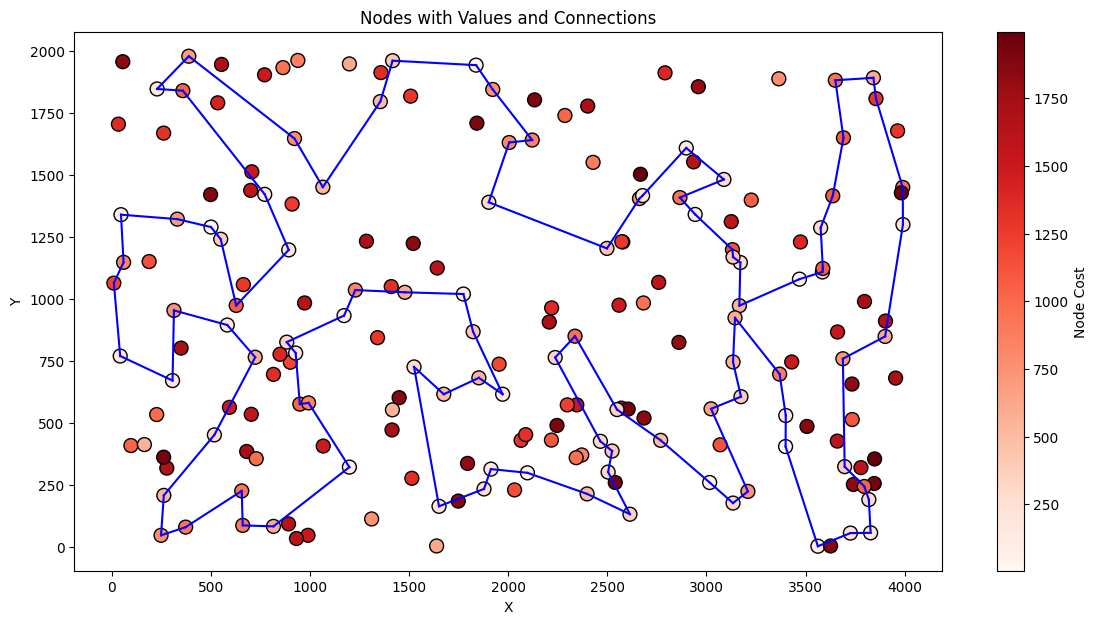

In [26]:
print("Evolutionary Solution with ERX recombination, No Local Search on TSPA")
solutions, iterations = evolutionary_solution(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=ERX_recombination, local_search=False)

temp = copy_scores(solutions)
TSPA_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_A, solution)

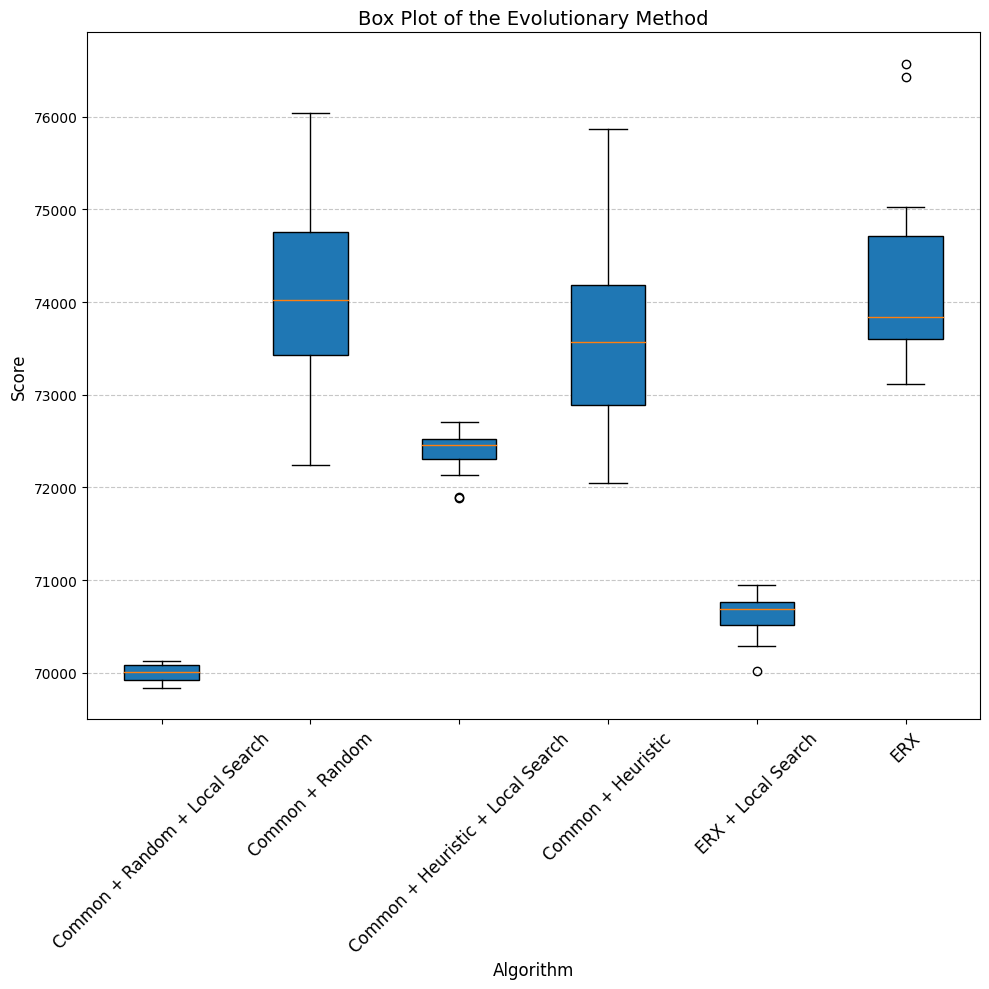

In [27]:
plot_boxes_evolutionary(TSPA_cumulative_results, labels=["Common + Random + Local Search", "Common + Random", "Common + Heuristic + Local Search", "Common + Heuristic", "ERX + Local Search", "ERX"])

#### Visualization Experiments

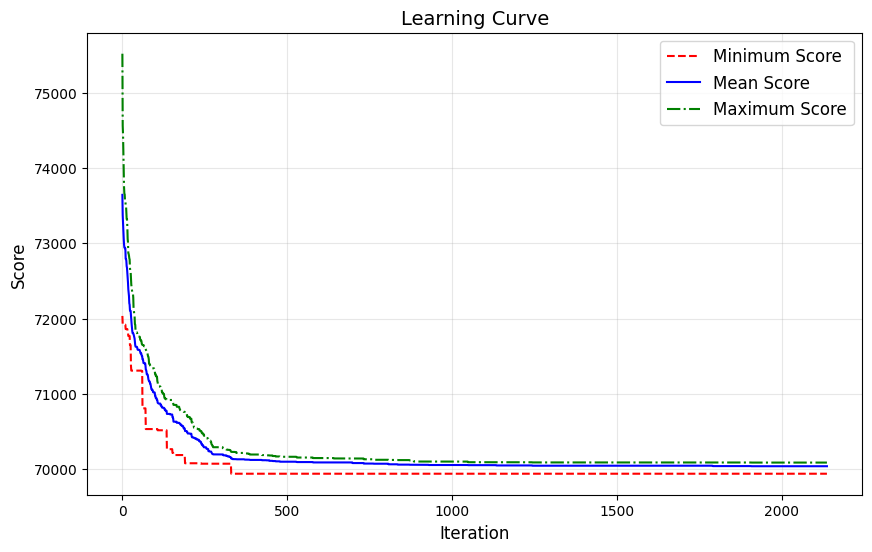

In [28]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_random_recombination, local_search=True)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)

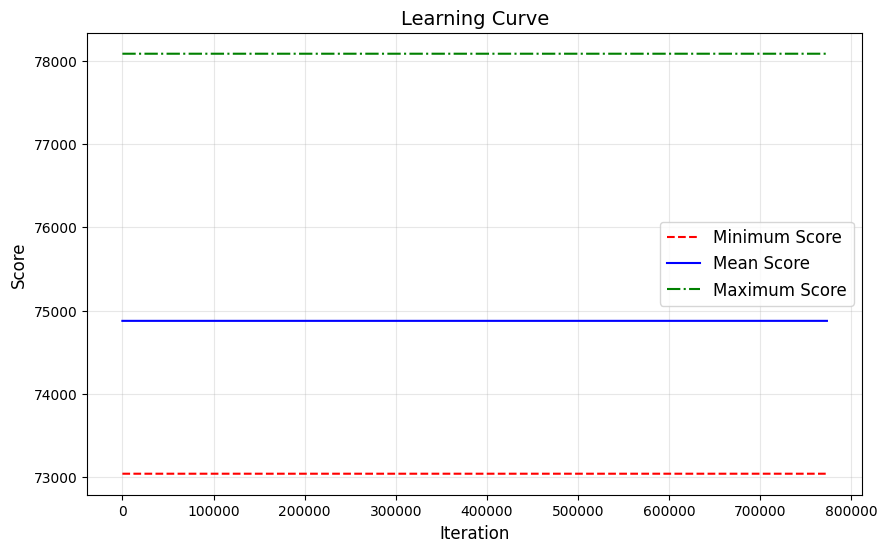

In [29]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_random_recombination, local_search=False)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)

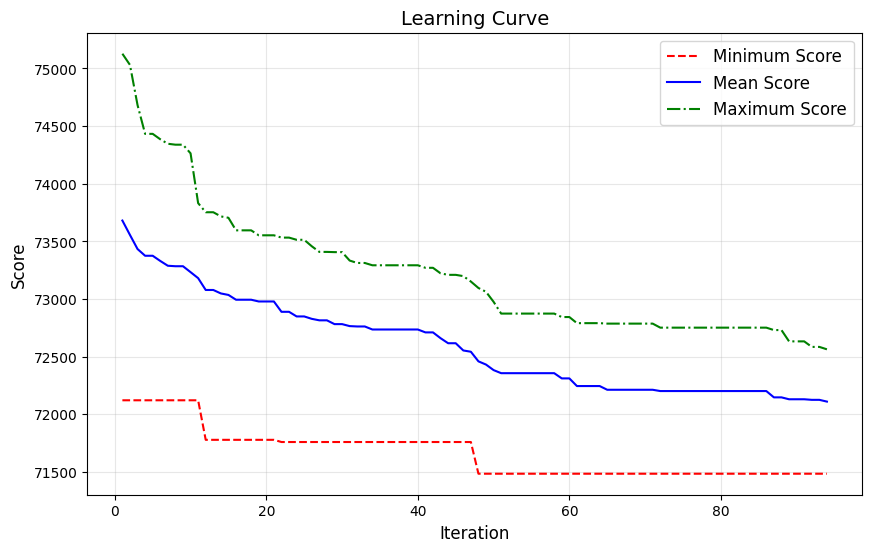

In [30]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_heuristic_recombination, local_search=True)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)

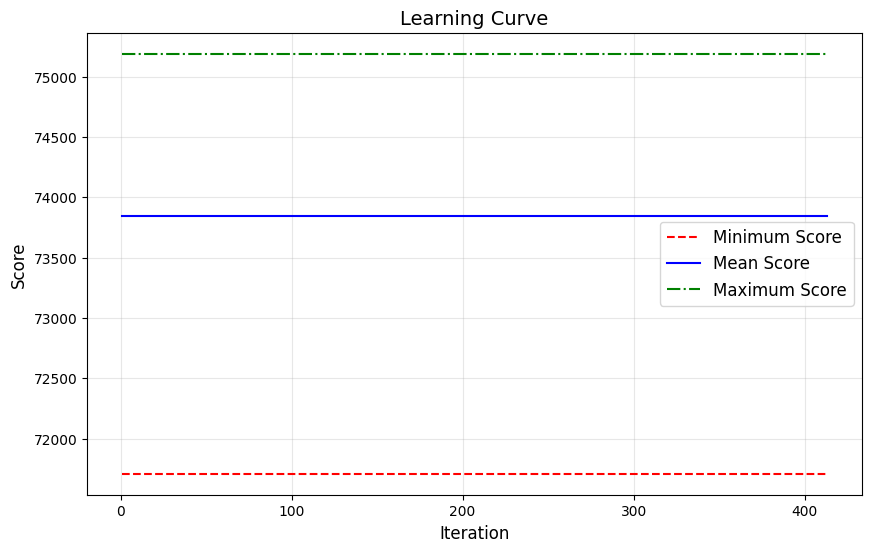

In [31]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_heuristic_recombination, local_search=False)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)

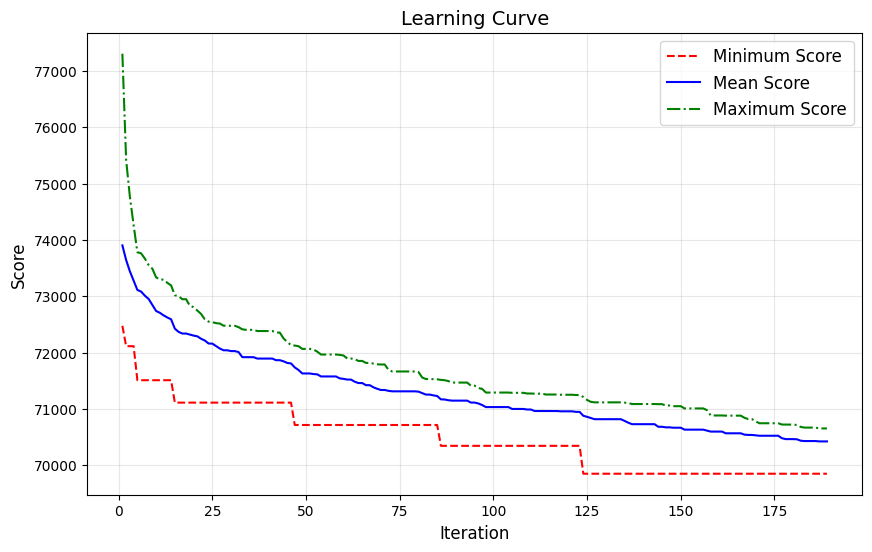

In [32]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=ERX_recombination, local_search=True)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)

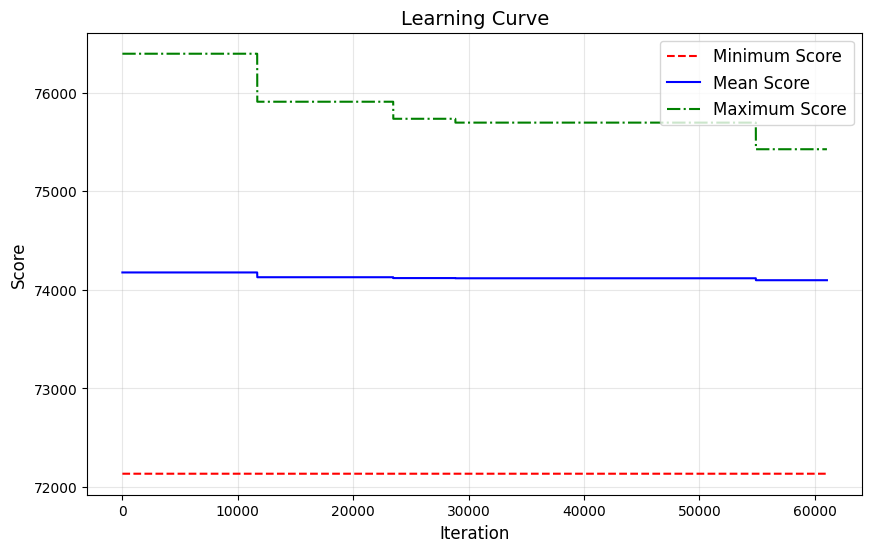

In [33]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_A, weights_A, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=ERX_recombination, local_search=False)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)

### TSPB

In [34]:
df_B = pd.read_csv(TSPB_PATH, sep=";", header=None)
df_B.columns = ["x", "y", "val"]
distance_matrix_B = get_distance_matrix(df_B, euclidean_distance)
weights_B = df_B.val.to_numpy()
weights_B[:2]

array([ 40, 247], dtype=int64)

In [35]:
allowed_time = 90.37019

In [36]:
TSPB_cumulative_results = []

#### Performance Experiments

Evolutionary Solution with Common + Random recombination, Local Search Used on TSPB
Achieved Best Score: 43884
Achieved Mean Score: 44017
Achieved Worst Score: 44087
44017 (43884 - 44087))
Solution: [97, 141, 61, 36, 177, 5, 78, 175, 142, 45, 80, 190, 136, 73, 54, 31, 193, 117, 198, 156, 1, 27, 38, 135, 63, 40, 107, 133, 122, 131, 121, 51, 90, 147, 6, 188, 169, 132, 13, 70, 3, 15, 145, 195, 168, 139, 11, 138, 33, 160, 144, 56, 104, 8, 21, 82, 111, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 152, 183, 140, 4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 176, 113, 114, 137, 127, 89, 103, 163, 187, 153, 81, 77]
Number of iterations: 2308


C:\Users\barte\AppData\Local\Temp\ipykernel_820\438370808.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


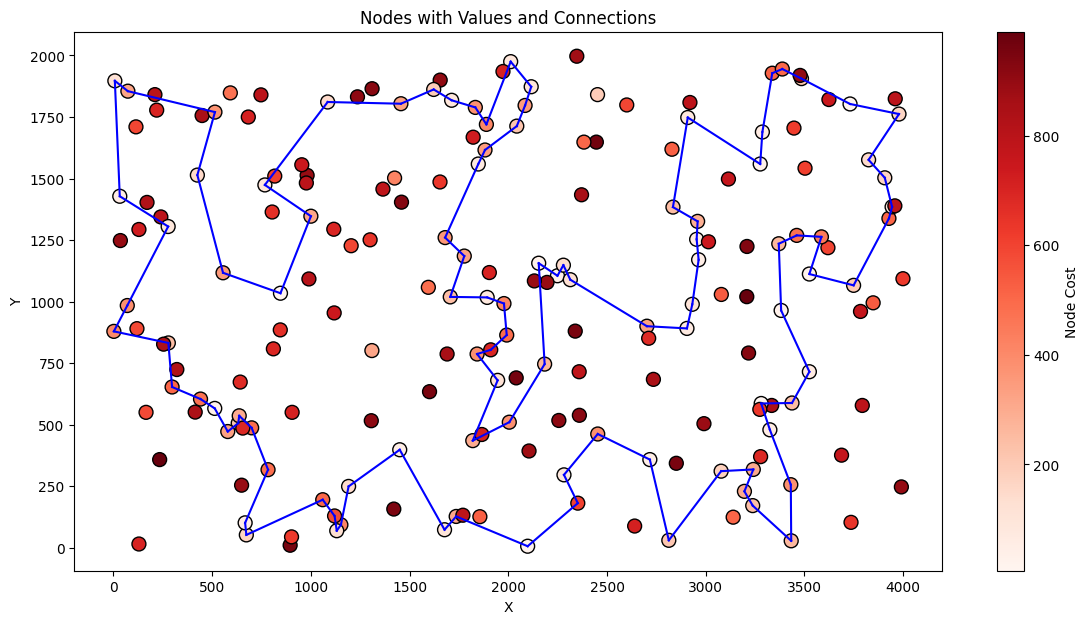

In [37]:
print("Evolutionary Solution with Common + Random recombination, Local Search Used on TSPB")
solutions, iterations = evolutionary_solution(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_random_recombination, local_search=True)

temp = copy_scores(solutions)
TSPB_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_B, solution)

Evolutionary Solution with Common + Random recombination, No Local Search on TSPB
Achieved Best Score: 46931
Achieved Mean Score: 48800
Achieved Worst Score: 50831
48800 (46931 - 50831))
Solution: [138, 33, 160, 144, 56, 104, 8, 111, 29, 0, 35, 109, 155, 152, 170, 34, 55, 18, 62, 143, 106, 124, 128, 95, 183, 140, 28, 20, 148, 47, 94, 66, 179, 99, 185, 86, 166, 194, 176, 113, 26, 103, 114, 127, 89, 163, 187, 153, 81, 77, 141, 61, 36, 175, 78, 5, 177, 25, 112, 19, 54, 31, 73, 136, 80, 190, 193, 117, 198, 156, 1, 16, 27, 38, 135, 63, 40, 107, 122, 90, 125, 131, 121, 51, 118, 74, 134, 147, 6, 188, 169, 132, 70, 3, 15, 145, 13, 195, 168, 11]
Number of iterations: 671469


C:\Users\barte\AppData\Local\Temp\ipykernel_820\3196977952.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


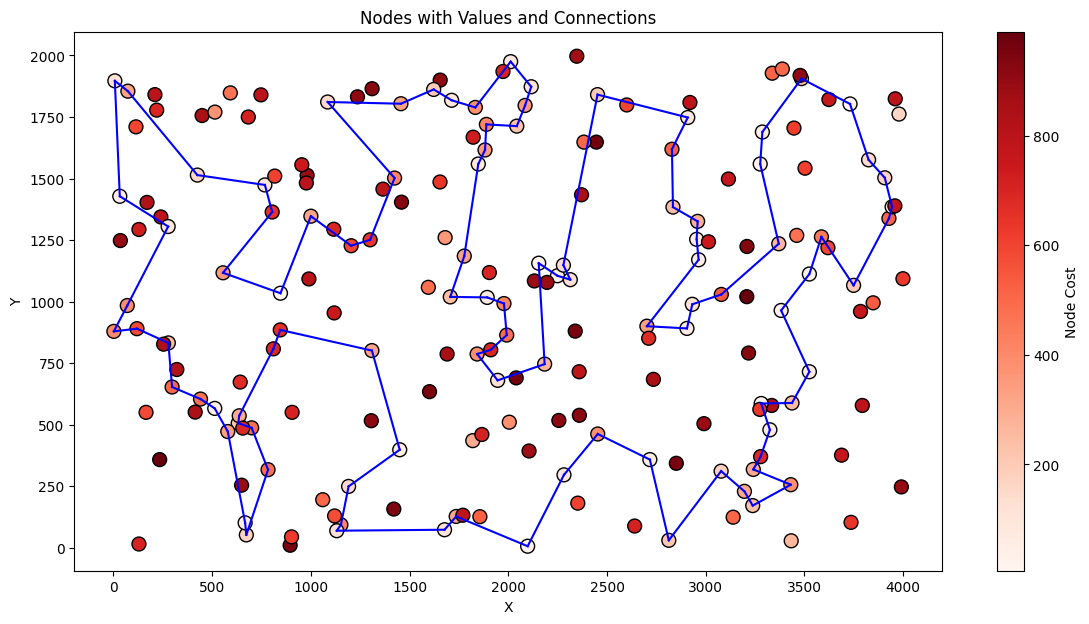

In [38]:
print("Evolutionary Solution with Common + Random recombination, No Local Search on TSPB")
solutions, iterations = evolutionary_solution(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_random_recombination, local_search=False)

temp = copy_scores(solutions)
TSPB_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_B, solution)

Evolutionary Solution with Common + Heuristic recombination, Local Search Used on TSPB
Achieved Best Score: 46611
Achieved Mean Score: 47405
Achieved Worst Score: 48051
47405 (46611 - 48051))
Solution: [0, 109, 35, 111, 8, 144, 160, 33, 138, 104, 21, 82, 77, 81, 153, 163, 89, 127, 103, 113, 180, 176, 106, 124, 62, 18, 55, 183, 140, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 95, 86, 166, 194, 114, 137, 165, 187, 146, 97, 141, 61, 36, 177, 5, 78, 175, 45, 162, 80, 190, 136, 73, 164, 54, 31, 193, 117, 198, 156, 24, 1, 16, 27, 38, 131, 121, 51, 90, 122, 135, 102, 63, 40, 107, 133, 10, 147, 6, 188, 169, 132, 70, 3, 15, 145, 13, 126, 195, 168, 29]
Number of iterations: 82


C:\Users\barte\AppData\Local\Temp\ipykernel_820\2819681463.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


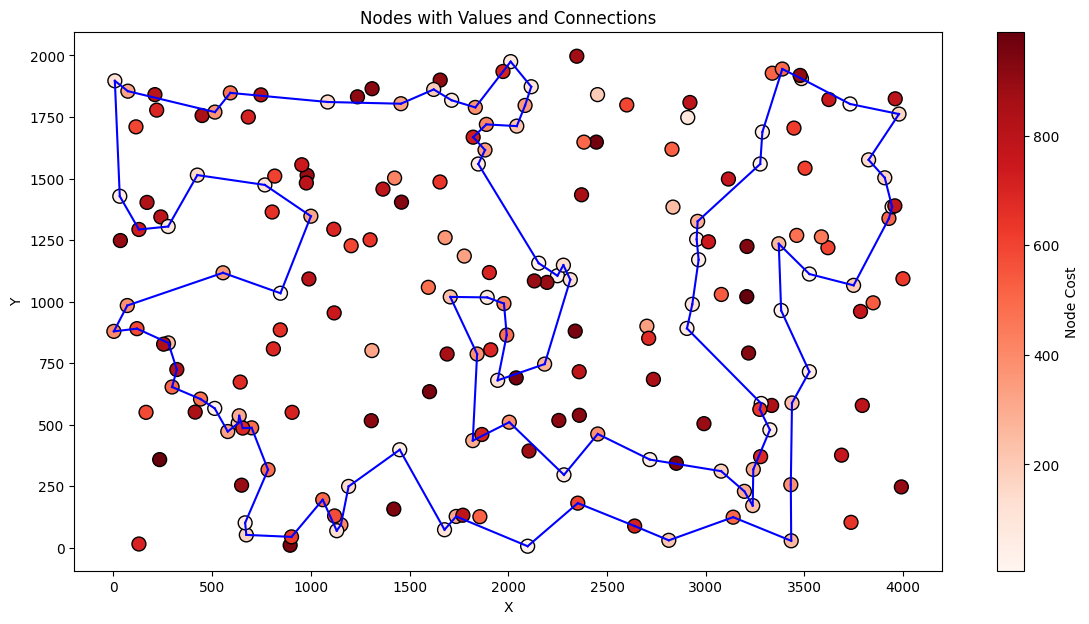

In [39]:
print("Evolutionary Solution with Common + Heuristic recombination, Local Search Used on TSPB")
solutions, iterations = evolutionary_solution(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_heuristic_recombination, local_search=True)

temp = copy_scores(solutions)
TSPB_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_B, solution)

Evolutionary Solution with Common + Heuristic recombination, No Local Search on TSPB
Achieved Best Score: 47111
Achieved Mean Score: 48566
Achieved Worst Score: 50888
48566 (47111 - 50888))
Solution: [145, 15, 70, 3, 189, 155, 184, 152, 183, 140, 4, 149, 28, 59, 20, 60, 148, 47, 94, 179, 185, 130, 95, 55, 34, 18, 62, 124, 106, 86, 166, 194, 176, 180, 113, 103, 127, 165, 89, 163, 153, 81, 77, 141, 36, 61, 21, 82, 111, 159, 143, 35, 109, 0, 29, 160, 144, 56, 8, 104, 33, 11, 139, 138, 182, 25, 177, 5, 78, 175, 80, 190, 73, 54, 31, 193, 117, 198, 1, 63, 135, 131, 19, 112, 121, 125, 51, 120, 191, 90, 122, 133, 147, 6, 188, 169, 132, 13, 195, 168]
Number of iterations: 276


C:\Users\barte\AppData\Local\Temp\ipykernel_820\1483975566.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


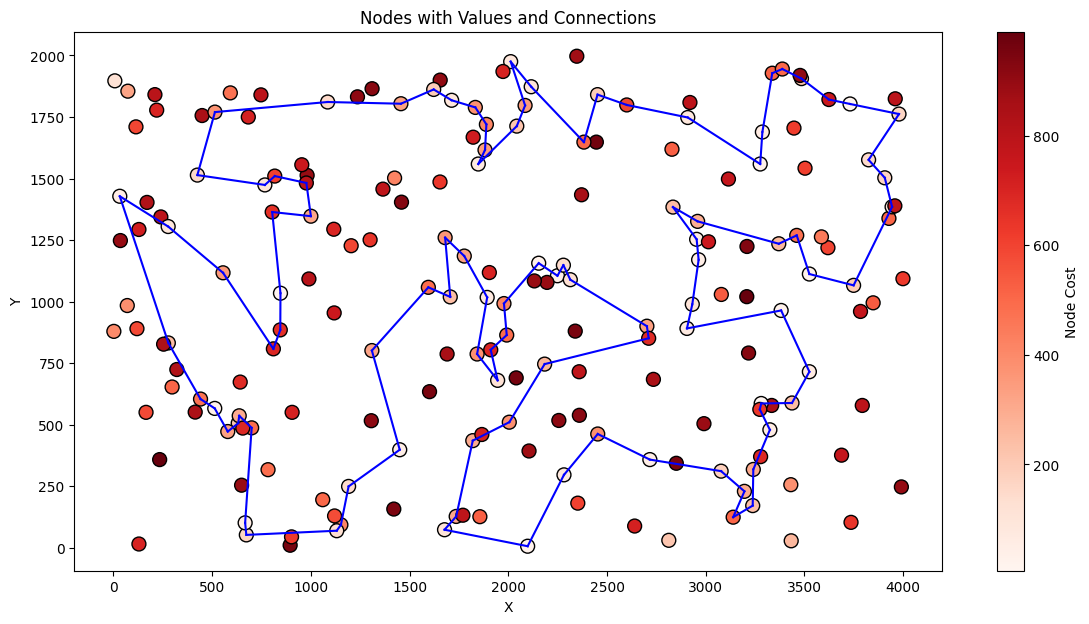

In [40]:
print("Evolutionary Solution with Common + Heuristic recombination, No Local Search on TSPB")
solutions, iterations = evolutionary_solution(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_heuristic_recombination, local_search=False)

temp = copy_scores(solutions)
TSPB_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_B, solution)

Evolutionary Solution with ERX recombination, Local Search Used on TSPB
Achieved Best Score: 44575
Achieved Mean Score: 44947
Achieved Worst Score: 45244
44947 (44575 - 45244))
Solution: [155, 3, 70, 132, 169, 188, 6, 147, 90, 51, 121, 131, 135, 122, 107, 40, 63, 38, 27, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 45, 142, 175, 78, 5, 177, 36, 61, 91, 21, 82, 141, 97, 77, 81, 153, 187, 163, 103, 89, 127, 137, 114, 113, 176, 194, 166, 86, 185, 95, 130, 99, 179, 94, 47, 148, 20, 28, 149, 4, 140, 183, 152, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 111, 8, 104, 56, 144, 160, 33, 11, 138, 182, 139, 168, 195, 13, 145, 15]
Number of iterations: 178


C:\Users\barte\AppData\Local\Temp\ipykernel_820\392948320.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


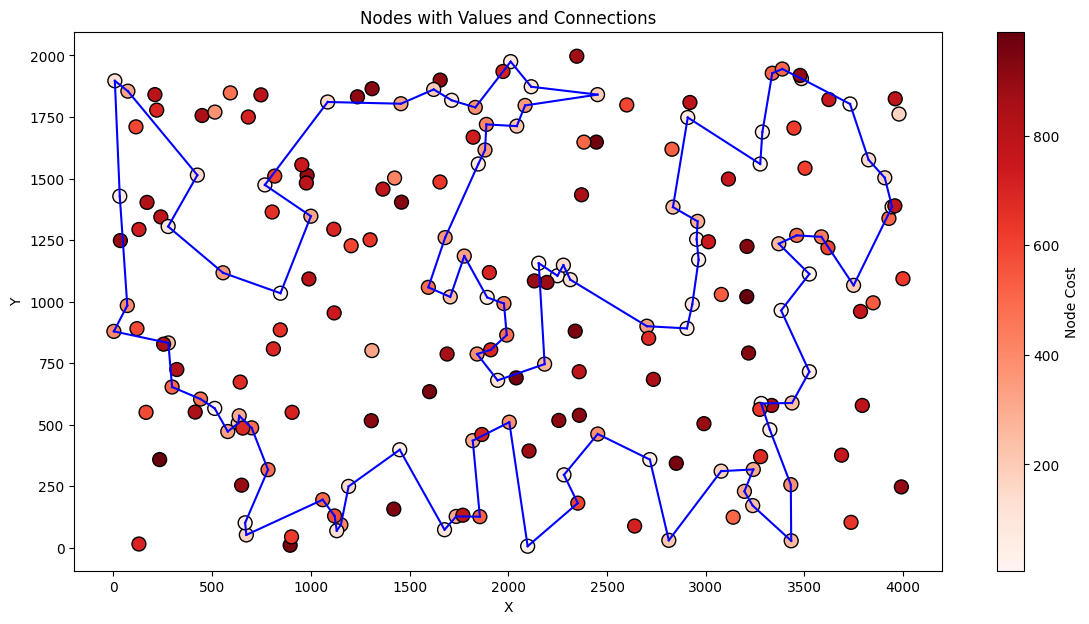

In [41]:
print("Evolutionary Solution with ERX recombination, Local Search Used on TSPB")
solutions, iterations = evolutionary_solution(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=ERX_recombination, local_search=True)

temp = copy_scores(solutions)
TSPB_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_B, solution)

Evolutionary Solution with ERX recombination, No Local Search Used on TSPB
Achieved Best Score: 46856
Achieved Mean Score: 47880
Achieved Worst Score: 48519
47880 (46856 - 48519))
Solution: [153, 187, 165, 127, 89, 163, 103, 114, 113, 180, 176, 194, 166, 86, 95, 185, 179, 94, 47, 148, 20, 140, 183, 152, 34, 55, 18, 62, 124, 106, 143, 111, 8, 82, 87, 21, 104, 56, 144, 0, 35, 109, 29, 168, 195, 145, 15, 3, 70, 132, 169, 188, 6, 147, 71, 191, 90, 51, 134, 139, 11, 160, 33, 138, 182, 25, 158, 19, 112, 121, 131, 135, 122, 133, 107, 40, 63, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 45, 142, 175, 78, 5, 177, 36, 61, 91, 141, 77, 81]
Number of iterations: 55978


C:\Users\barte\AppData\Local\Temp\ipykernel_820\2570248278.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  numpy_scores = np.array(solutions)[:, 0]


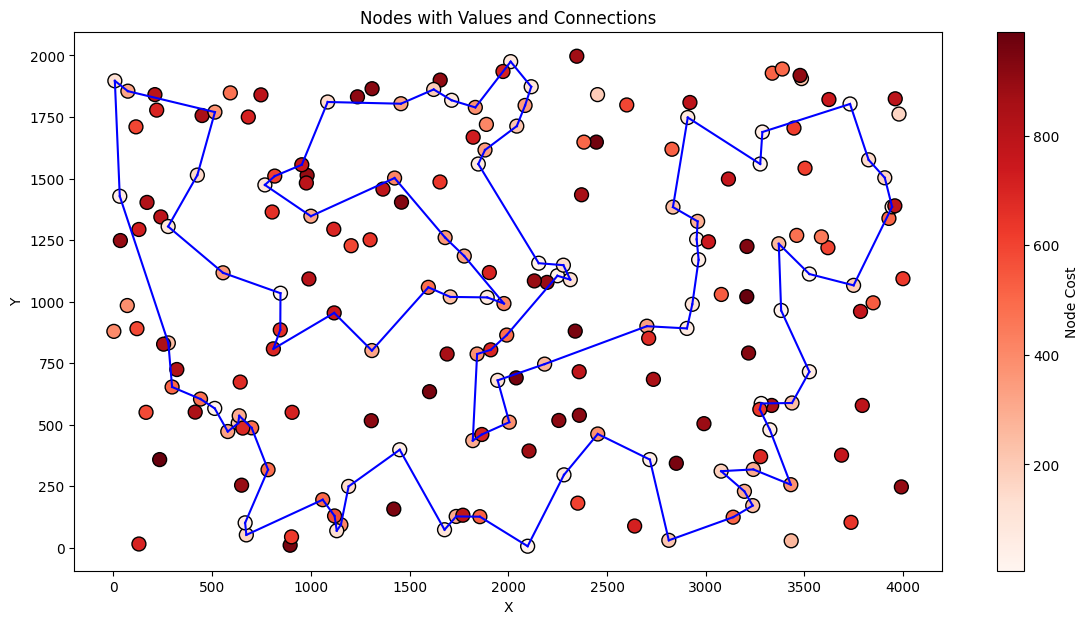

In [42]:
print("Evolutionary Solution with ERX recombination, No Local Search Used on TSPB")
solutions, iterations = evolutionary_solution(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=ERX_recombination, local_search=False)

temp = copy_scores(solutions)
TSPB_cumulative_results.append(temp.copy())
score = -1*solutions[0][0]
solution = solutions[0][1]

worst_score = -1*solutions[-1][0]
numpy_scores = np.array(solutions)[:, 0]
avr_score = np.mean(numpy_scores)
print(f"Achieved Best Score: {score}")
print(f"Achieved Mean Score: {-1*avr_score}")
print(f"Achieved Worst Score: {worst_score}")
print(f"{-1*avr_score} ({score} - {worst_score}))")

print(f"Solution: {solution}")
print(f"Number of iterations: {iterations}")
plot_nodes_with_lines(df_B, solution)

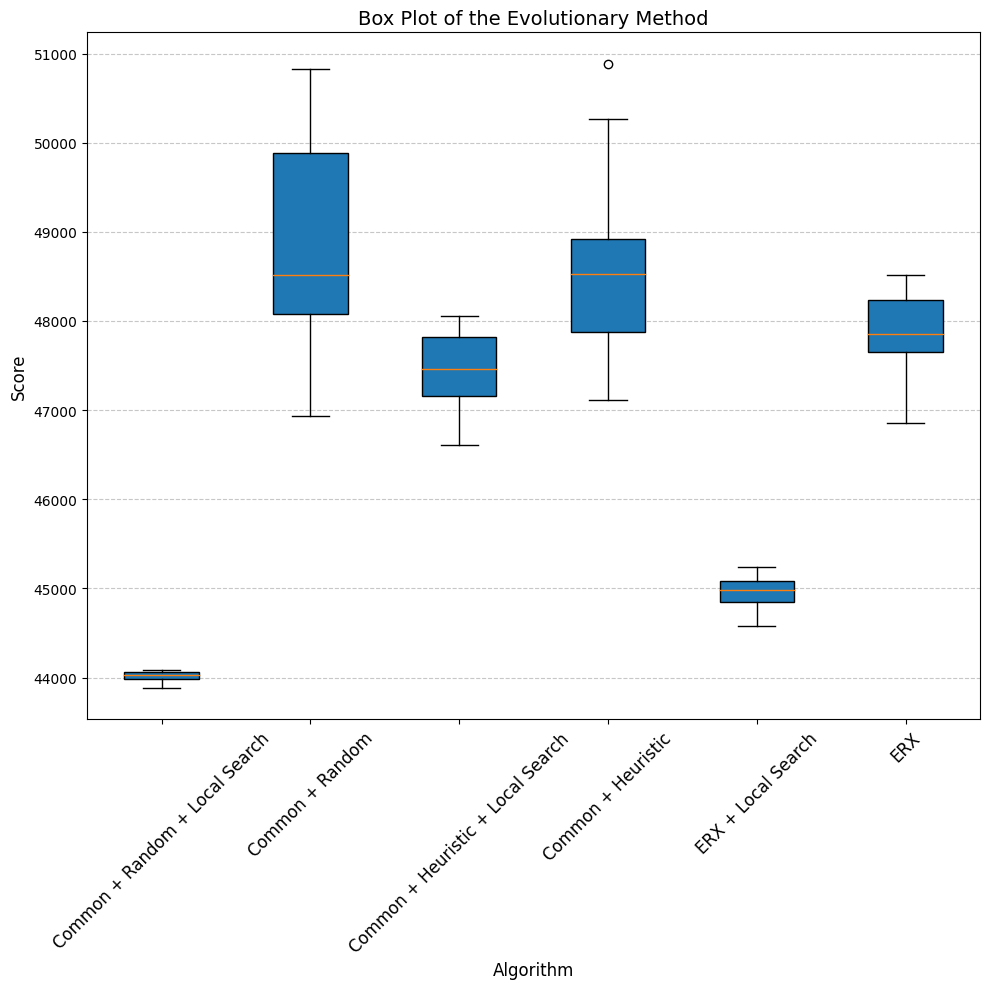

In [43]:
plot_boxes_evolutionary(TSPB_cumulative_results, labels=["Common + Random + Local Search", "Common + Random", "Common + Heuristic + Local Search", "Common + Heuristic", "ERX + Local Search", "ERX"])

#### Visualization Experiments

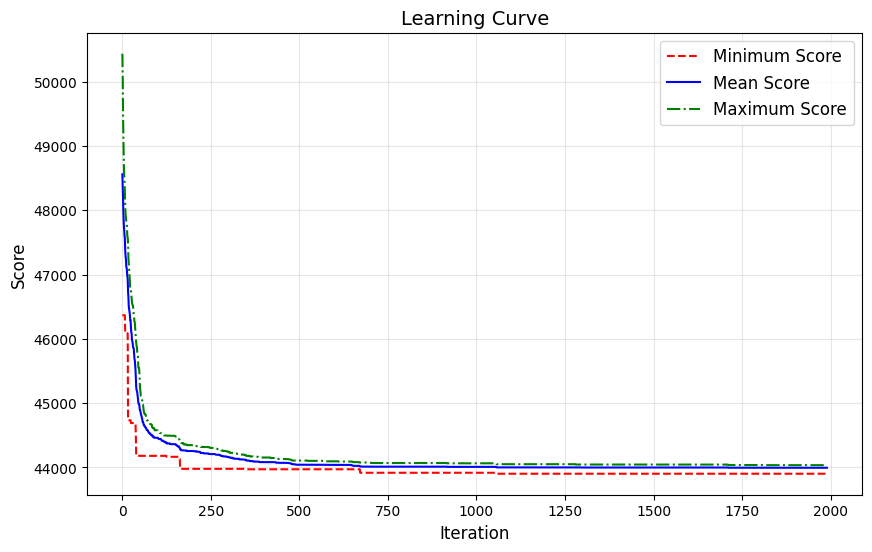

In [44]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_random_recombination, local_search=True)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)

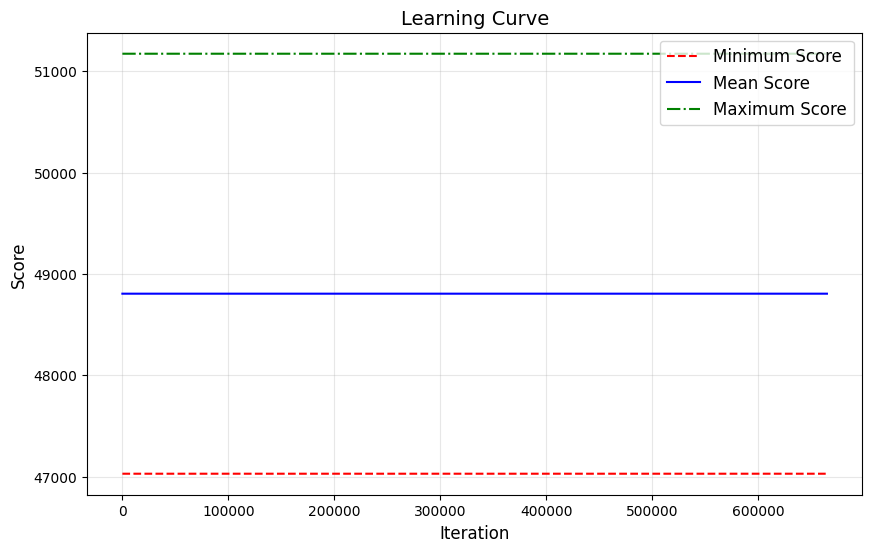

In [45]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_random_recombination, local_search=False)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)

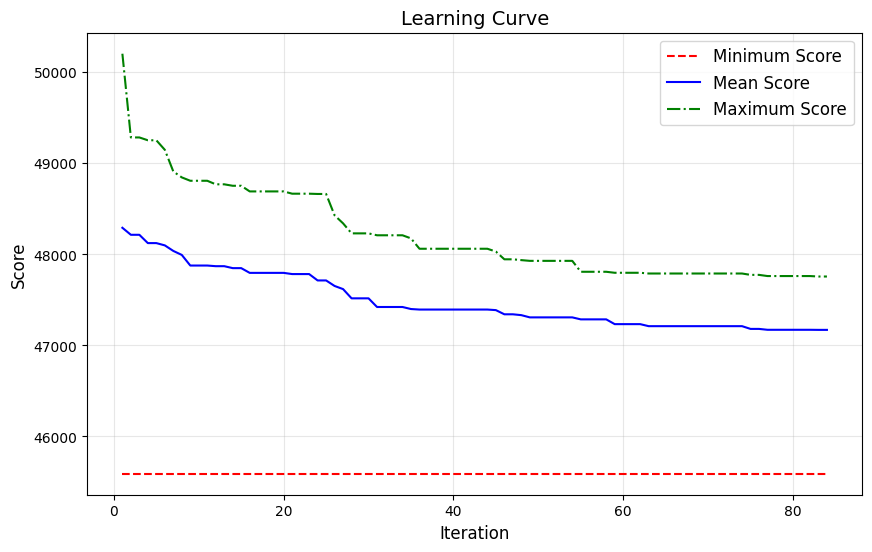

In [46]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_heuristic_recombination, local_search=True)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)

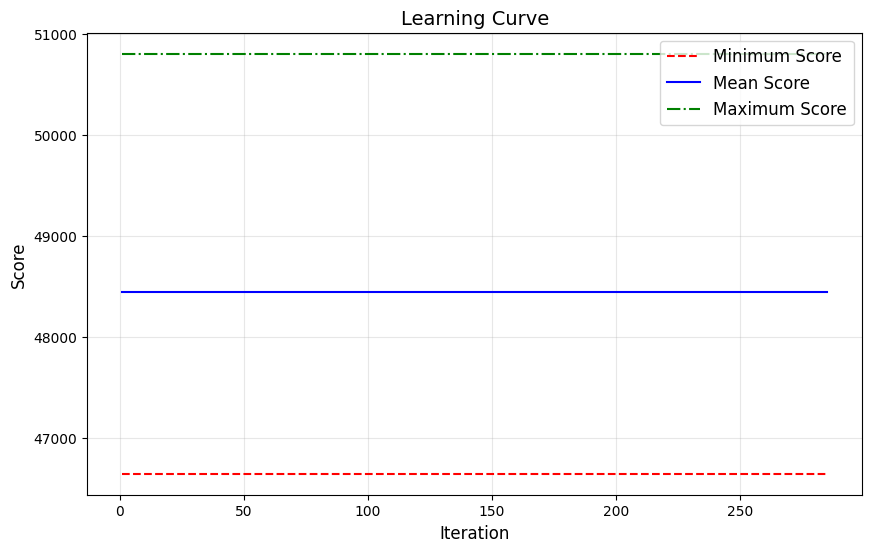

In [47]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=common_and_heuristic_recombination, local_search=False)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)

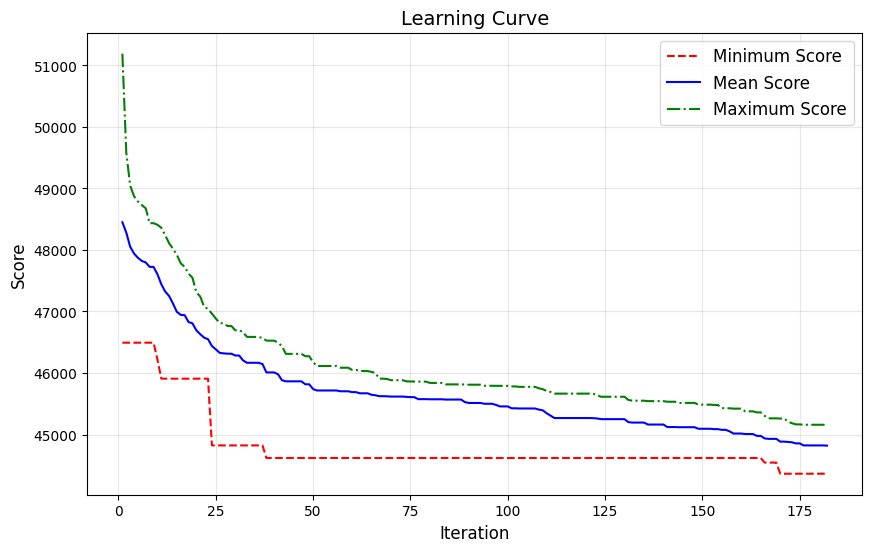

In [49]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=ERX_recombination, local_search=True)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)

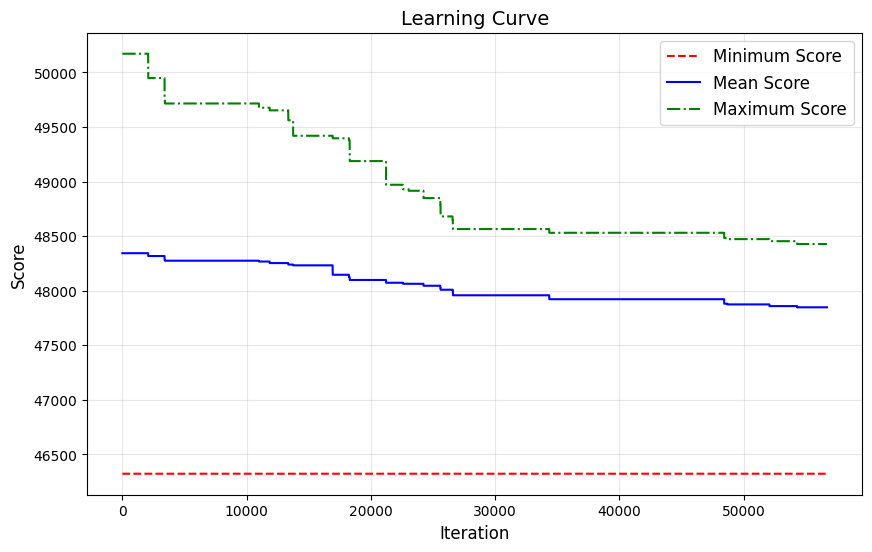

In [50]:
solutions_history, iterations = evolutionary_solution_entire_history(distance_matrix_B, weights_B, allowed_time=allowed_time, create_initial_population=create_initial_population_local_search,
                      pop_size=20, recombination=ERX_recombination, local_search=False)
scores_history = get_scores_history(solutions_history)
plot_learning_curve(scores_history)